In [1]:
import asyncio
from copra.websocket import Channel, Client
import matplotlib.pyplot as plt
from collections import OrderedDict
from time import sleep
from dateutil import parser
import copy
import datetime
import itertools
from operator import itemgetter
import numpy as np
from dateutil.tz import tzutc
import math
import pytz
from pytz import timezone
import pickle
import pylab
from scipy.stats import probplot,expon,kstest
import matplotlib.pyplot as plt

# Load Data

In [2]:
def parse_file(file_name):
    raw_updates = []
    with open(file_name,"rb") as f:
        starting_time,starting_bids,starting_asks = list(pickle.load(f))
        while True:
            try:
                raw_updates.append(pickle.load(f))
            except EOFError:
                break
    
    Bids = {}
    Asks = {}    
    
    updates = []
    
    for price, amount in starting_bids:
        Bids[int(round((float(price)*100)))] = float(amount)
    for price, amount in starting_asks:
        Asks[int(round((float(price)*100)))] = float(amount)
        
    for u in raw_updates:
        price = int(round((float(u["price"])*100)))  
        side = u["side"]
        amount = float(u["amount"])
        time = parser.parse(u["time"])
        
        if side == "buy":
            change = amount - Bids.get(price,0)
        else:
            change = amount - Asks.get(price,0)
        
        updates.append({\
            "Bids": copy.copy(Bids), \
            "Asks": copy.copy(Asks), \
            "time": time, \
            "side": side, \
            "price": price, \
            "change": change            
        })
        
        if side == "buy":
            if amount == "0":
                del Bids[price]
            else:
                Bids[price] = float(amount)
        else:
            if amount == "0":
                del Asks[price]
            else:
                Asks[price] = float(amount)   

    
    return(starting_time, updates)

parsed_file = parse_file("12_25_18_data.pkl")
len(parsed_file[1])

28870

In [3]:
def shortened_updates(file_name,K):
    starting_time, updates = parse_file(file_name)
    
    res = []
    
    # Caluclate first reference price
    starting_bids = updates[0]['Bids']
    starting_asks = updates[0]['Asks']
    sorted_bids = list(reversed(sorted(starting_bids.items())))
    sorted_asks = list(sorted(starting_asks.items()))        
    best_bid = sorted_bids[0][0]
    best_ask = sorted_asks[0][0]
    if ((best_bid + best_ask) % 2) != 0:
        old_reference_price = round((best_bid+best_ask)/2, 1)
    else:
        old_reference_price = round((best_bid+best_ask+1)/2, 1)
            
    for u in updates:      
        # Find reference price
        sorted_bids = list(reversed(sorted(u['Bids'].items())))
        sorted_asks = list(sorted(u['Asks'].items()))        
        best_bid = sorted_bids[0][0]
        best_ask = sorted_asks[0][0]
        if ((best_bid + best_ask) % 2) != 0:
            reference_price = round((best_bid+best_ask)/2, 1)
        else:
            middle = (best_bid+best_ask)/2
            if old_reference_price > middle:
                reference_price = round((best_bid+best_ask)/2 + 0.5,1)
            else:
                old_reference_price = round((best_bid+best_ask)/2 - 0.5,1)
                
        shortened_book = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
        first_bid = int(round(reference_price - 0.5))
        first_ask = int(round(reference_price + 0.5))        
        for k in range(-K,0):
            shortened_book[k] = u['Bids'].get(first_bid + k + 1,0)
        for k in range(1,K+1):
            shortened_book[k] = u['Asks'].get(first_ask + k - 1,0)
            
        # Find k from the price. Keep track of event if
        # abs(k) <= K
        price = u["price"]
        k = price - reference_price
        if k < 0:
            k = int(round(k - 0.5))
        else:
            k = int(round(k + 0.5))
        if abs(k) <= K:                 
            res.append({
                'reference_price': reference_price,
                'LOB': copy.copy(shortened_book),
                'k': k,
                'change': u['change'],
                'time': u['time']
            })
        
        old_reference_price = reference_price

    return starting_time, res

starting_time,updates = shortened_updates('12_25_18_data.pkl',10)
len(updates)

27922

# Combine Updates that Occur At Same Time

In [4]:
grouped_by_time = OrderedDict([(k, list(v)) for k, v in itertools.groupby(updates, key=lambda x:x['time'])])
# Contains dictionary of time, reference price, order book, list of changes
cleaned_updates = []
for t, us in grouped_by_time.items():
    if len(us) == 1:
        u = us[0]
        cleaned_updates.append(copy.copy(u))
    else:
        new_update = {'time': t}
        us = sorted(us, key=lambda u:-abs(u['k']))
        grouped_by_k = OrderedDict((k, list(v)) for k, v in itertools.groupby(us, key=lambda u:u['k']))
        reference_k = list(grouped_by_k.keys())[0]
        new_update['reference_price'] = grouped_by_k[reference_k][0]['reference_price']
        new_update['LOB'] = copy.copy(grouped_by_k[reference_k][0]['LOB'])
        events = []
        for k in grouped_by_k:
            combined_change = 0
            for u in grouped_by_k[k]:
                combined_change = combined_change + u['change']
            events.append((k,combined_change))
        for k,change in events:
            new_update = copy.deepcopy(new_update)
            new_update['k'] = k
            new_update['change'] = change
            cleaned_updates.append(new_update)

cleaned_updates
len(cleaned_updates)

27720

# Combine Orders that Occur in Quick Succession
### (Orders that occur within 0.01 seconds of each other)

In [5]:
combined_updates = []
i = 0
while i < len(cleaned_updates):
    reference_price = cleaned_updates[i]['reference_price']
    j = i
    updates_at_reference = []
    while (j < len(cleaned_updates)) and (cleaned_updates[j]['reference_price'] == reference_price):
        updates_at_reference.append(cleaned_updates[j])
        j += 1
    updates_at_reference = sorted(updates_at_reference,key=lambda u:u['k'])
    grouped_by_k = OrderedDict((k, list(v)) for k, v in itertools.groupby(updates_at_reference, key=lambda u:u['k']))
    for k,us in grouped_by_k.items():
        us = copy.deepcopy(sorted(us,key=lambda u:u['time']))
        keep_index = [True for u in us]
        for m in reversed(range(1,len(us))):
            quick_same_order = (us[m]['time'] - us[m-1]['time']).total_seconds() < 0.01
            same_sign = (us[m]['change'] * us[m-1]['change']) > 0
            if quick_same_order and same_sign:
                us[m-1]['change'] += us[m]['change']
                keep_index[m] = False
        for (u,keep) in zip(us, keep_index):
            if keep:
                combined_updates.append(u)
    i = j + 1
    
combined_updates = sorted(combined_updates,key=lambda u:u['time'])
len(combined_updates)

26870

# Calculate Average Event Size at Each Position

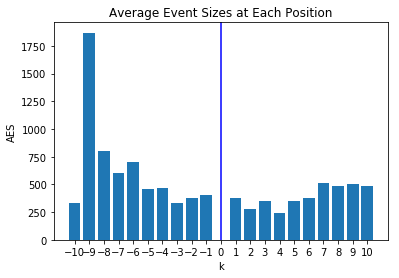

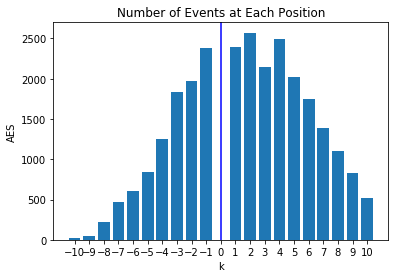

In [6]:
K = 10
starting_ref_price = 457.5
# Get Average Event Sizes
event_sizes = OrderedDict([(i,[]) for i in range(-K,K+1) if i != 0])
for update in combined_updates:
    event_sizes[update['k']].append(abs(update['change']))
AESs = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
numbers_of_events = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
for (k,event_sizes) in event_sizes.items():
    AESs[k] = np.mean(event_sizes)
    numbers_of_events[k] = len(event_sizes)
    
k,AES = zip(*AESs.items())
        
b1 = plt.bar(k, AES)
v = plt.axvline(x=0, color='b')
plt.xticks([i for i in range(-K,K+1)])        
plt.title('Average Event Sizes at Each Position')
plt.xlabel('k')
plt.ylabel('AES')
plt.show()

k,number_of_events = zip(*numbers_of_events.items())
b1 = plt.bar(k, number_of_events)
v = plt.axvline(x=0, color='b')
plt.xticks([i for i in range(-K,K+1)])        
plt.title('Number of Events at Each Position')
plt.xlabel('k')
plt.ylabel('AES')
plt.show()

# Get time between events at each position and queue size

In [8]:
def transform_book(book):
    res = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
    for k,actual_size in book.items():
        if math.isnan(AESs[k]):
            size = 1
        else:
            size = int(actual_size / AESs[k])
        res[k] = size
    return res

# Get times between events
maximum_sizes = OrderedDict([(k,0) for k in range(-K,K+1) if k != 0])
for update in combined_updates:
    transformed_book = transform_book(update['LOB'])
    for k,size in transformed_book.items():
        if size > maximum_sizes[k]:
            maximum_sizes[k] = size
            
time_between_events_pos = OrderedDict([(k,OrderedDict()) for k in range(-K,K+1) if k != 0])
time_between_events_neg = OrderedDict([(k,OrderedDict()) for k in range(-K,K+1) if k != 0])

for k in range(-K,K+1):
    if k != 0:
        for i in range(maximum_sizes[k] + 1):
            time_between_events_pos[k][i] = []
        for i in range(1,maximum_sizes[k] + 1):
            time_between_events_neg[k][i] = []           
                
t = starting_time
reference_change_time = t
last_change_time_at_k = OrderedDict([(k,reference_change_time) for k in range(-K,K+1) if k != 0])
old_reference_price = starting_ref_price

for update in combined_updates:
    reference_price = update['reference_price']
    transformed_book = transform_book(update['LOB'])
    t = update['time']
    if reference_price != old_reference_price:
        last_change_time_at_k = OrderedDict([(k,reference_change_time) for k in range(-K,K+1) if k != 0])
        reference_change_time = t
        old_reference_price = reference_price

    k = update['k']
    time_between_change = (t-last_change_time_at_k[k]).total_seconds()
    size = transformed_book[k]
    if update['change'] > 0:
        time_between_events_pos[k][size].append(time_between_change)
        last_change_time_at_k[k]= t
    else:
        if size > 0:
            time_between_events_neg[k][size].append(time_between_change)
            last_change_time_at_k[k] = t 

# QQ Plots of Times Between Events Compared to Exponential Distribution

k = -8, size = 0
Number of positive jump times: 71
Mean: 7.984647887323943


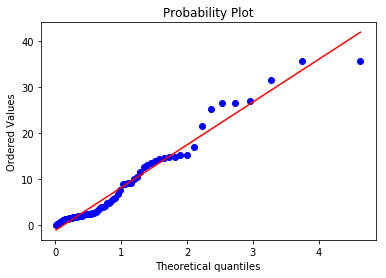



k = -7, size = 0
Number of positive jump times: 65
Mean: 4.042353846153846


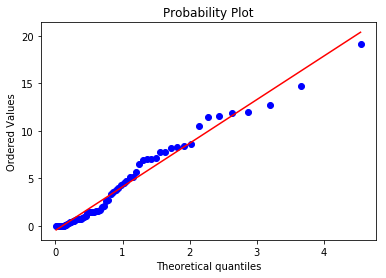



k = -7, size = 1
Number of positive jump times: 73
Mean: 0.2039178082191781


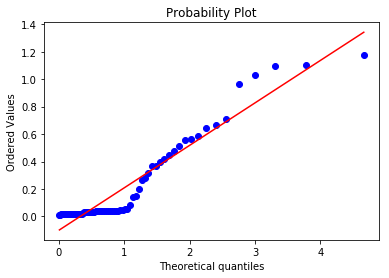



k = -7, size = 8
Number of positive jump times: 32
Mean: 2.83621875


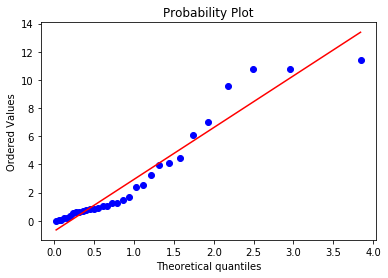



k = -6, size = 0
Number of positive jump times: 51
Mean: 5.275076450980391


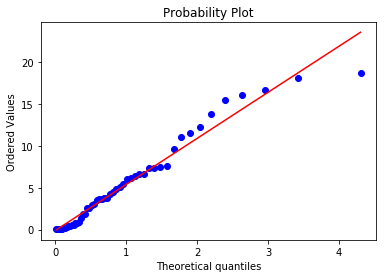



k = -6, size = 7
Number of positive jump times: 84
Mean: 0.35997619047619045


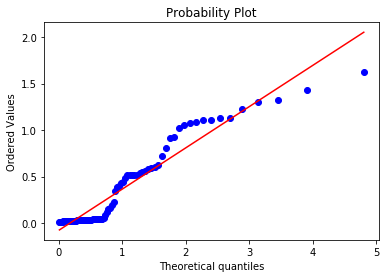



k = -6, size = 8
Number of positive jump times: 22
Mean: 1.3050454545454546


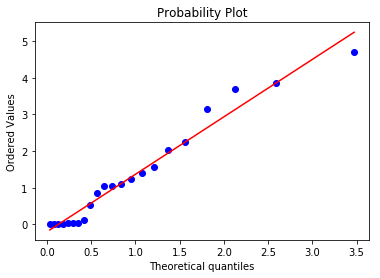



k = -6, size = 9
Number of positive jump times: 35
Mean: 1.6264285714285713


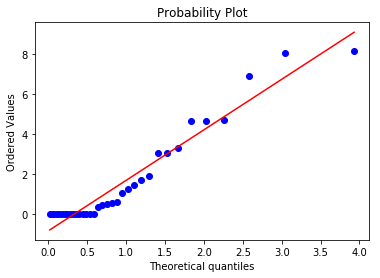



k = -5, size = 0
Number of positive jump times: 82
Mean: 1.074939024390244


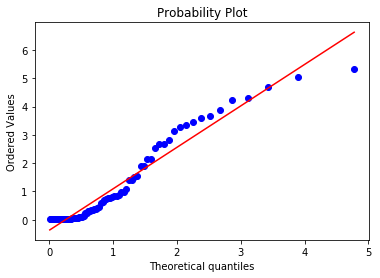



k = -5, size = 1
Number of positive jump times: 87
Mean: 1.6202873563218392


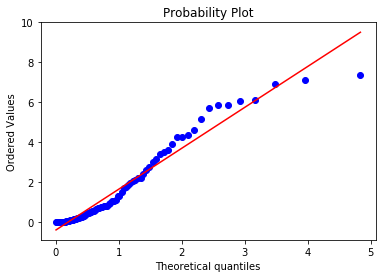



k = -5, size = 2
Number of positive jump times: 72
Mean: 0.6343472222222223


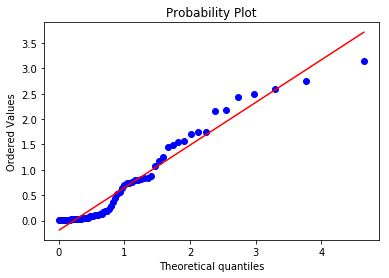



k = -5, size = 3
Number of positive jump times: 38
Mean: 1.8620263157894734


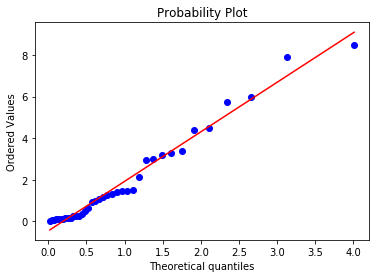



k = -5, size = 10
Number of positive jump times: 36
Mean: 3.6999444444444456


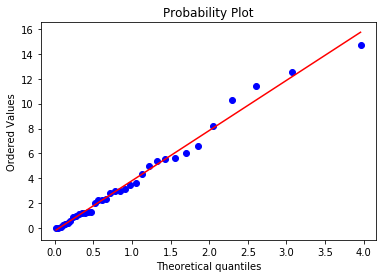



k = -4, size = 0
Number of positive jump times: 260
Mean: 1.1769884615384616


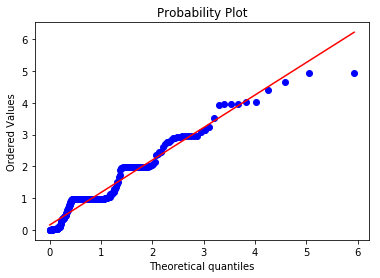



k = -4, size = 1
Number of positive jump times: 58
Mean: 2.7531896551724144


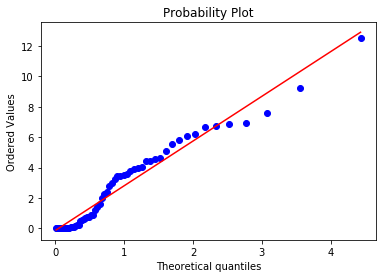



k = -4, size = 2
Number of positive jump times: 35
Mean: 0.6039114000000001


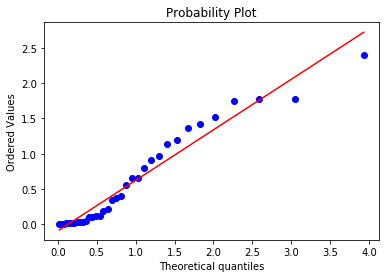



k = -4, size = 3
Number of positive jump times: 49
Mean: 0.7290204081632653


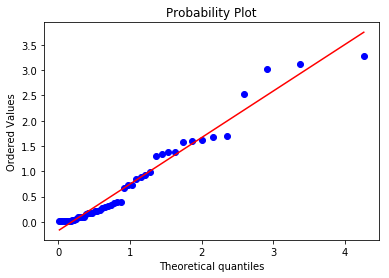



k = -4, size = 4
Number of positive jump times: 22
Mean: 0.6613181818181817


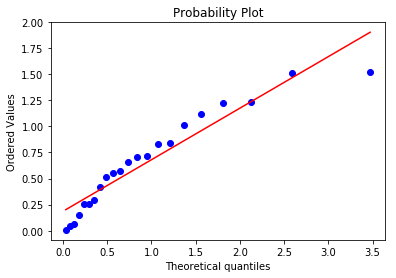



k = -4, size = 10
Number of positive jump times: 37
Mean: 1.4090270270270273


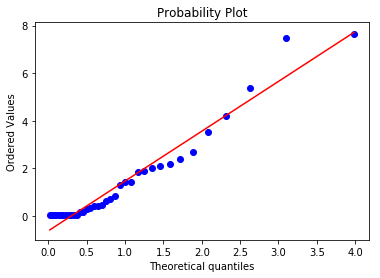



k = -4, size = 11
Number of positive jump times: 24
Mean: 0.3755833333333333


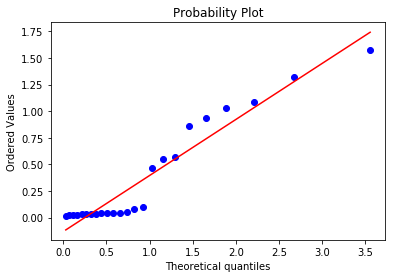



k = -3, size = 0
Number of positive jump times: 331
Mean: 1.2533051359516616


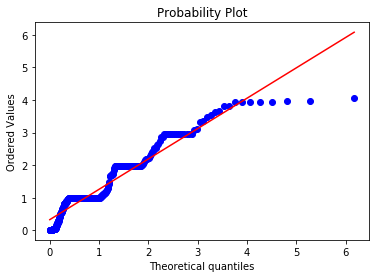



k = -3, size = 1
Number of positive jump times: 180
Mean: 0.7454555555555555


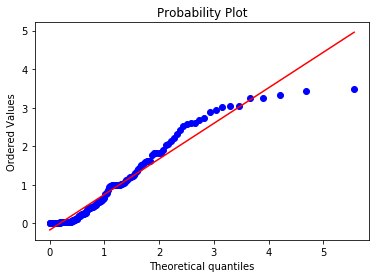



k = -3, size = 2
Number of positive jump times: 29
Mean: 0.8104827586206897


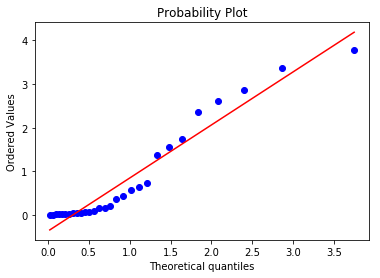



k = -3, size = 3
Number of positive jump times: 41
Mean: 1.5053170731707317


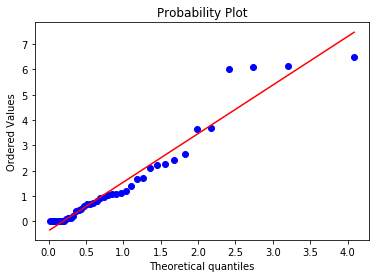



k = -3, size = 4
Number of positive jump times: 49
Mean: 0.23381632653061227


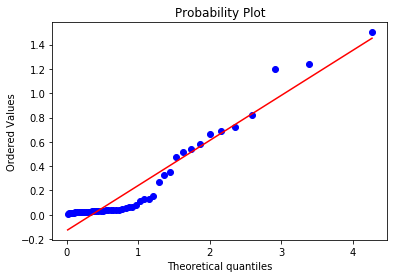



k = -3, size = 5
Number of positive jump times: 33
Mean: 1.6283030303030301


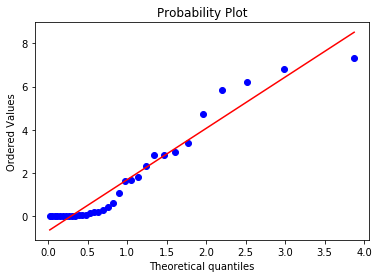



k = -3, size = 6
Number of positive jump times: 43
Mean: 2.756488372093023


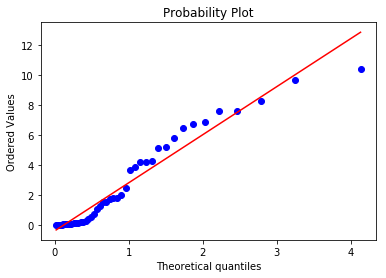



k = -3, size = 15
Number of positive jump times: 25
Mean: 0.5666


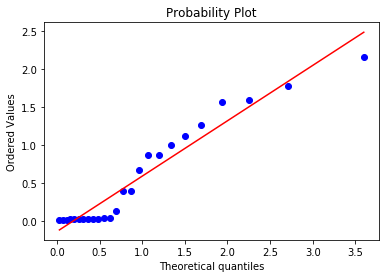



k = -2, size = 0
Number of positive jump times: 342
Mean: 1.448


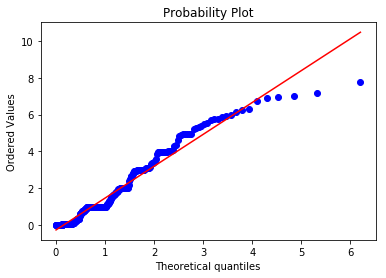



k = -2, size = 1
Number of positive jump times: 113
Mean: 0.5259999999999999


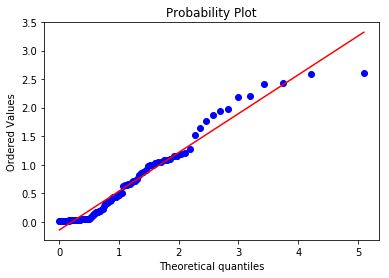



k = -2, size = 2
Number of positive jump times: 74
Mean: 1.8866486486486482


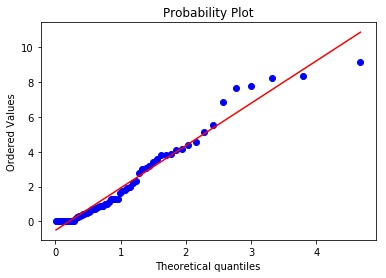



k = -2, size = 3
Number of positive jump times: 60
Mean: 1.22805


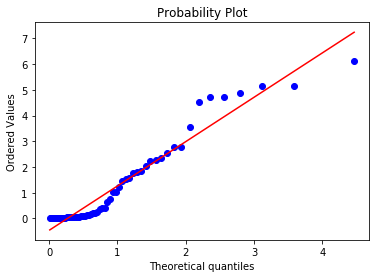



k = -2, size = 4
Number of positive jump times: 56
Mean: 0.32619642857142855


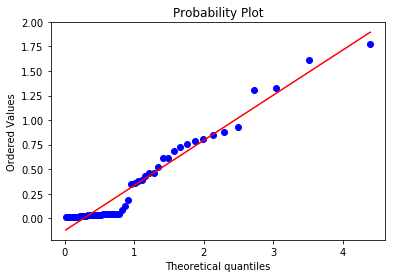



k = -2, size = 5
Number of positive jump times: 23
Mean: 1.234


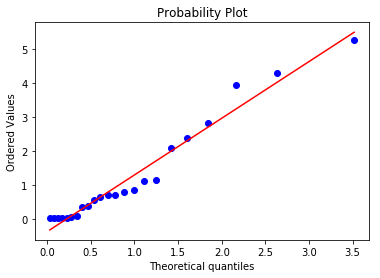



k = -2, size = 13
Number of positive jump times: 63
Mean: 0.332031746031746


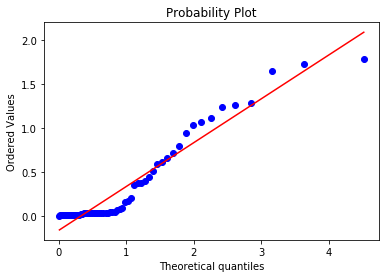



k = -2, size = 15
Number of positive jump times: 25
Mean: 1.2686000000000002


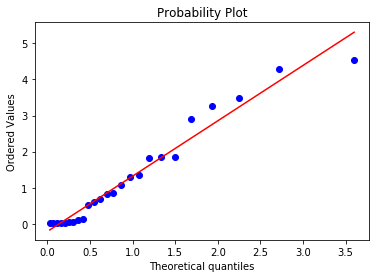



k = -1, size = 0
Number of positive jump times: 388
Mean: 1.3030850515463916


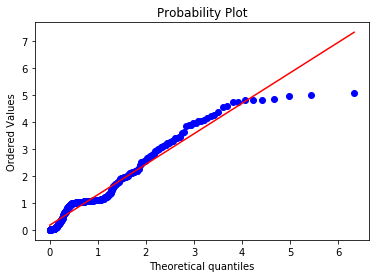



k = -1, size = 1
Number of positive jump times: 87
Mean: 0.43282758620689654


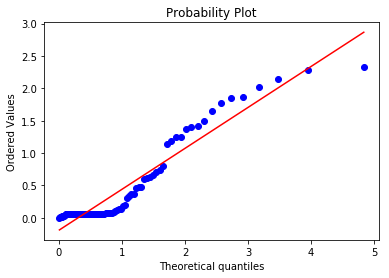



k = -1, size = 2
Number of positive jump times: 65
Mean: 1.8377538461538463


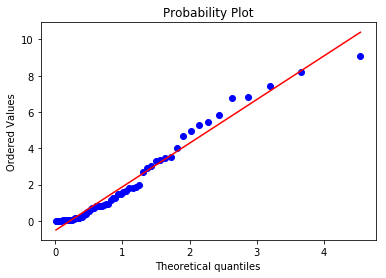



k = -1, size = 3
Number of positive jump times: 83
Mean: 0.6404698795180723


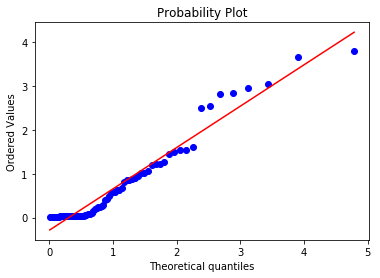



k = -1, size = 4
Number of positive jump times: 65
Mean: 0.39601538461538466


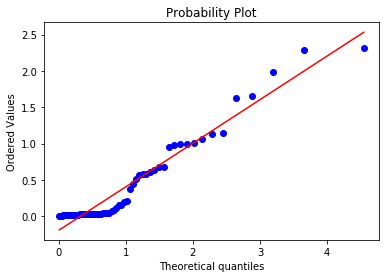



k = -1, size = 5
Number of positive jump times: 42
Mean: 1.3087857142857142


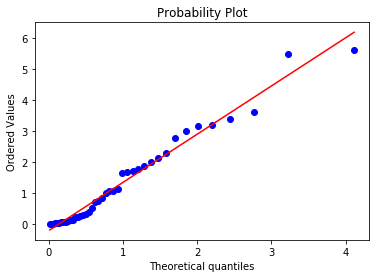



k = -1, size = 12
Number of positive jump times: 53
Mean: 0.03279245283018868


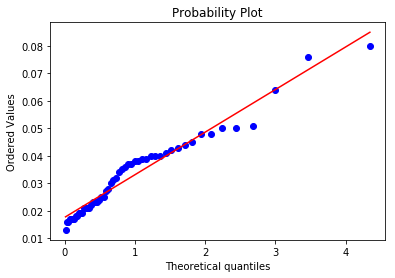



k = -1, size = 15
Number of positive jump times: 24
Mean: 0.42008333333333336


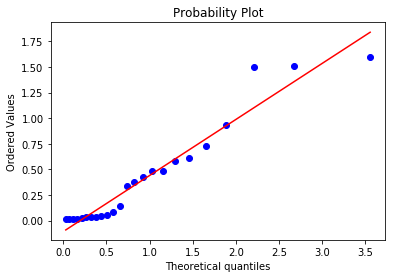



k = -1, size = 17
Number of positive jump times: 26
Mean: 0.689576923076923


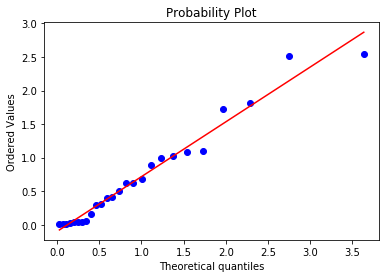



k = -1, size = 18
Number of positive jump times: 27
Mean: 1.0078518518518518


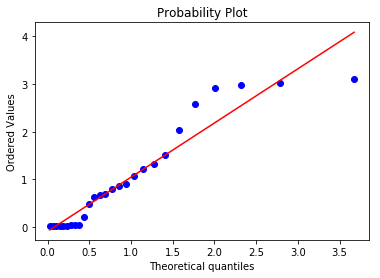



k = 1, size = 0
Number of positive jump times: 906
Mean: 3.2902714116997793


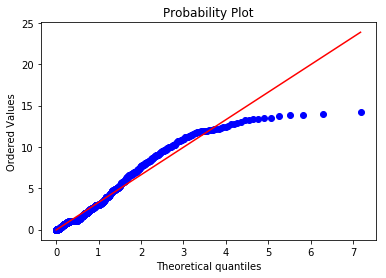



k = 1, size = 1
Number of positive jump times: 21
Mean: 0.43804761904761913


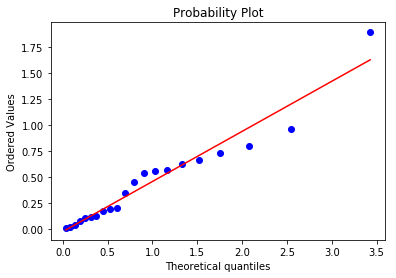



k = 1, size = 2
Number of positive jump times: 21
Mean: 2.301999999999999


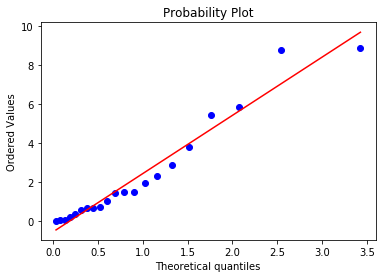



k = 2, size = 0
Number of positive jump times: 788
Mean: 1.750541878172589


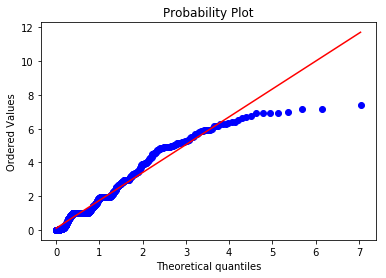



k = 2, size = 1
Number of positive jump times: 52
Mean: 0.5308653846153846


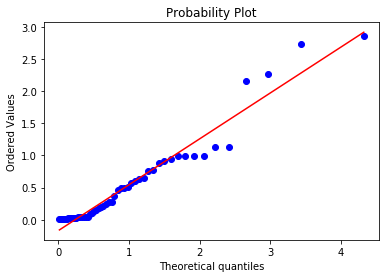



k = 2, size = 2
Number of positive jump times: 25
Mean: 1.5885199999999997


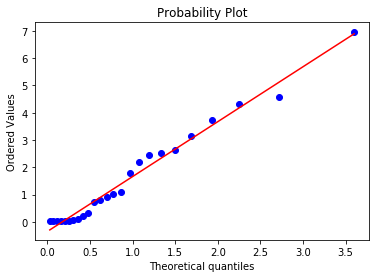



k = 2, size = 3
Number of positive jump times: 26
Mean: 0.6613846153846153


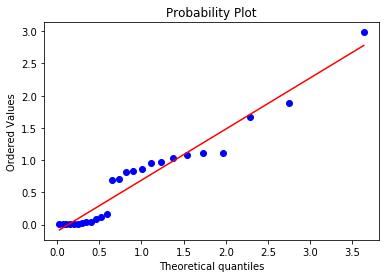



k = 2, size = 4
Number of positive jump times: 49
Mean: 0.4330816326530612


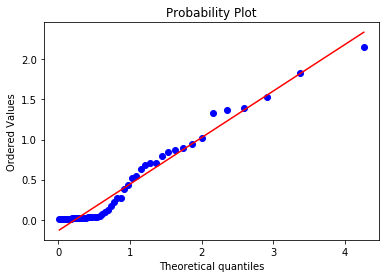



k = 2, size = 5
Number of positive jump times: 36
Mean: 0.6078888888888888


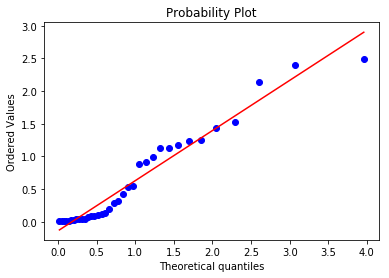



k = 2, size = 6
Number of positive jump times: 30
Mean: 0.05879999999999999


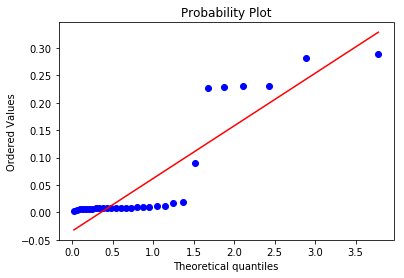



k = 3, size = 0
Number of positive jump times: 619
Mean: 2.9014523424878838


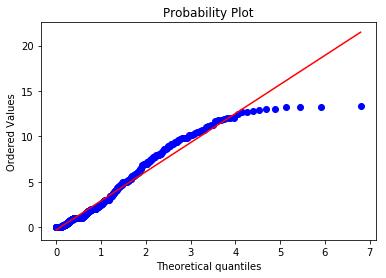



k = 3, size = 1
Number of positive jump times: 53
Mean: 1.8437358490566038


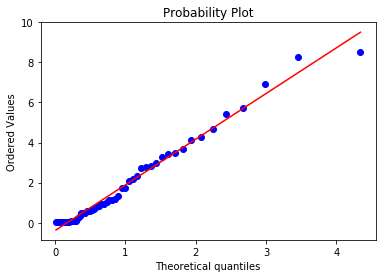



k = 3, size = 2
Number of positive jump times: 34
Mean: 1.6270588235294117


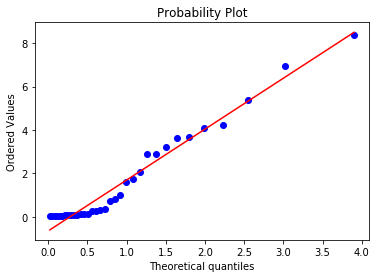



k = 3, size = 3
Number of positive jump times: 43
Mean: 1.7861627906976745


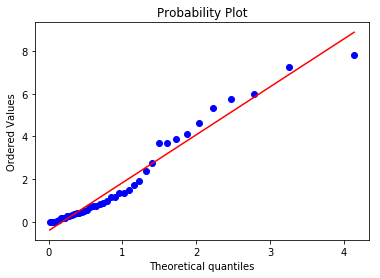



k = 3, size = 4
Number of positive jump times: 23
Mean: 1.5277826086956525


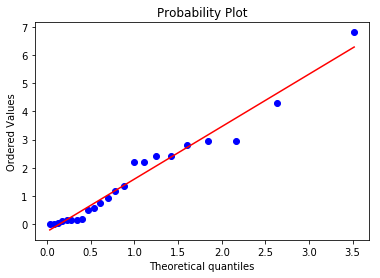



k = 3, size = 6
Number of positive jump times: 21
Mean: 0.32138095238095243


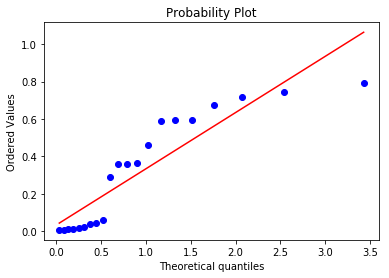



k = 3, size = 14
Number of positive jump times: 63
Mean: 0.03444444444444444


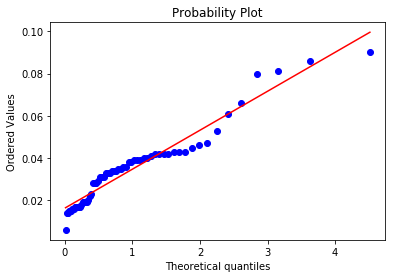



k = 3, size = 17
Number of positive jump times: 22
Mean: 1.8233181818181818


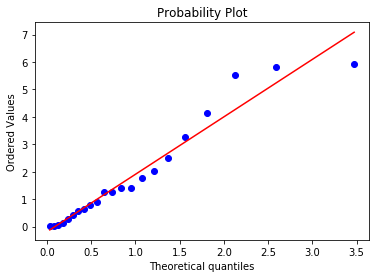



k = 4, size = 0
Number of positive jump times: 515
Mean: 1.6369009708737863


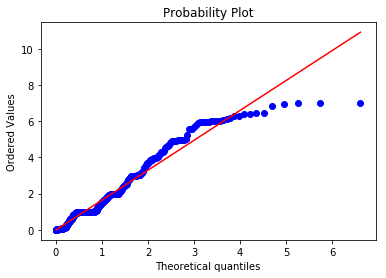



k = 4, size = 1
Number of positive jump times: 82
Mean: 1.7940000000000005


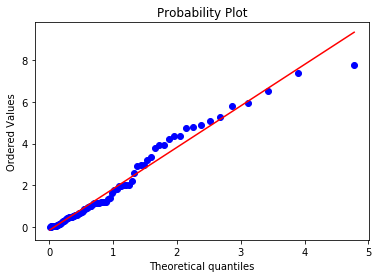



k = 4, size = 2
Number of positive jump times: 44
Mean: 2.2534318181818183


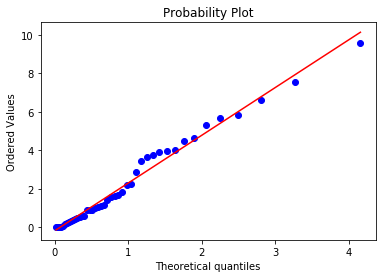



k = 4, size = 3
Number of positive jump times: 62
Mean: 2.2946129032258065


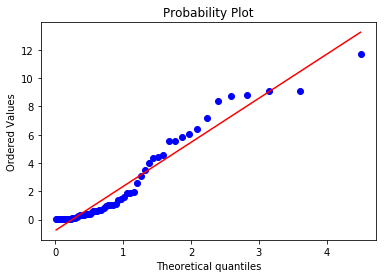



k = 4, size = 4
Number of positive jump times: 32
Mean: 0.38640625


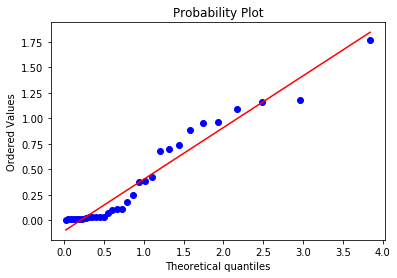



k = 4, size = 5
Number of positive jump times: 50
Mean: 0.42345999999999995


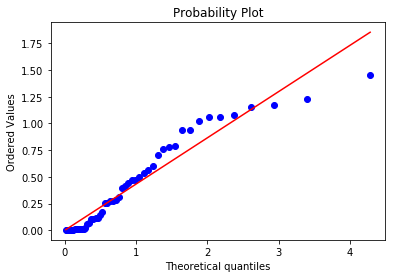



k = 4, size = 6
Number of positive jump times: 46
Mean: 0.3393695652173913


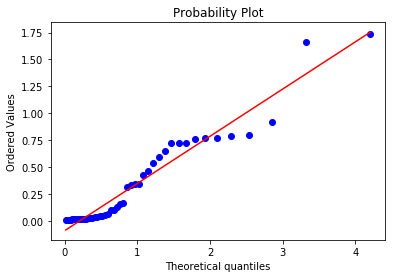



k = 4, size = 7
Number of positive jump times: 35
Mean: 0.41554285714285716


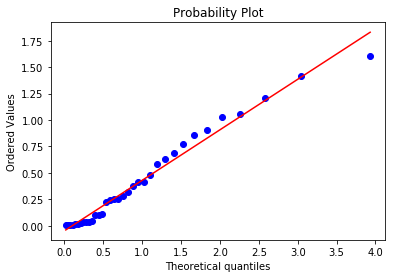



k = 4, size = 8
Number of positive jump times: 53
Mean: 0.6601320754716982


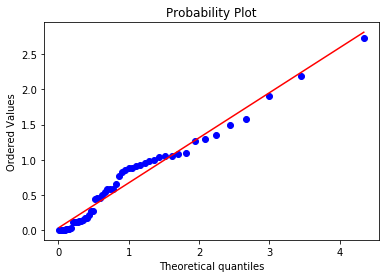



k = 4, size = 9
Number of positive jump times: 55
Mean: 0.35463636363636364


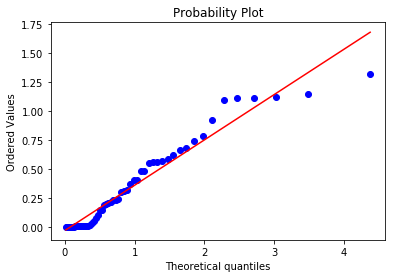



k = 4, size = 11
Number of positive jump times: 24
Mean: 0.28225


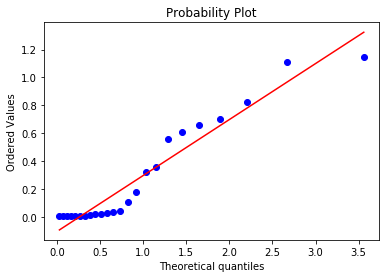



k = 5, size = 0
Number of positive jump times: 361
Mean: 1.2750637119113573


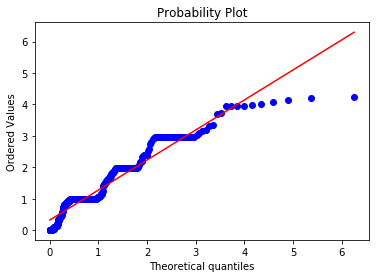



k = 5, size = 1
Number of positive jump times: 57
Mean: 1.1611578947368422


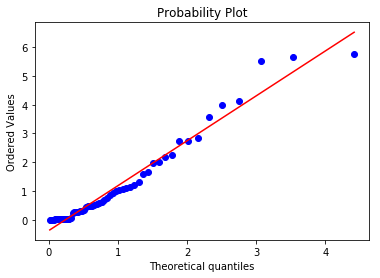



k = 5, size = 2
Number of positive jump times: 22
Mean: 0.14045454545454544


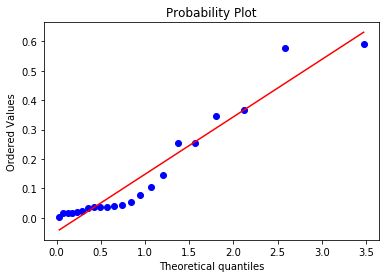



k = 5, size = 3
Number of positive jump times: 32
Mean: 4.48040625


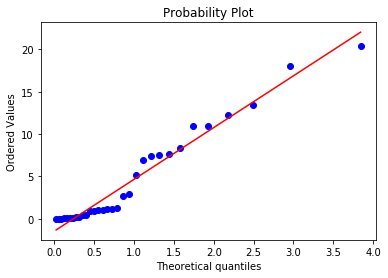



k = 5, size = 4
Number of positive jump times: 21
Mean: 2.832285714285714


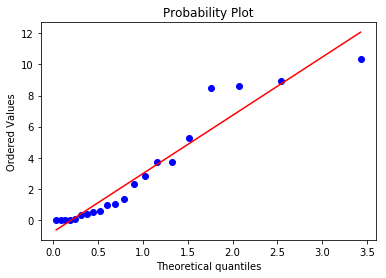



k = 5, size = 5
Number of positive jump times: 60
Mean: 0.4704000000000001


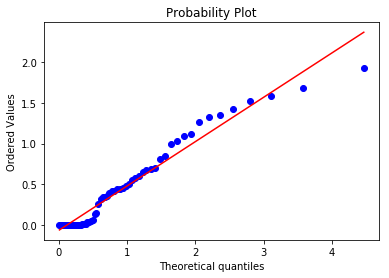



k = 5, size = 14
Number of positive jump times: 35
Mean: 0.029342857142857146


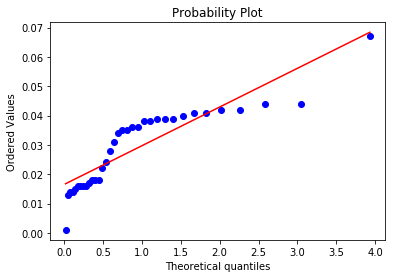



k = 5, size = 17
Number of positive jump times: 45
Mean: 0.37422222222222223


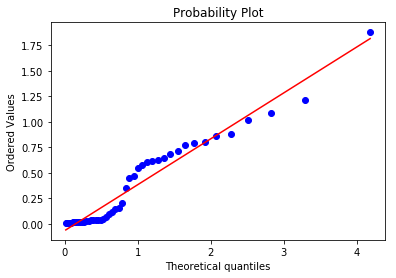



k = 5, size = 18
Number of positive jump times: 36
Mean: 0.39474999999999993


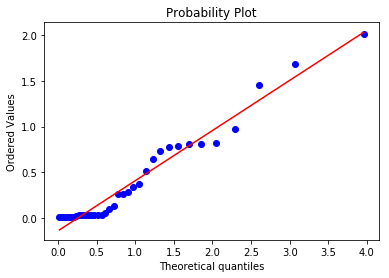



k = 5, size = 19
Number of positive jump times: 78
Mean: 0.7871794871794872


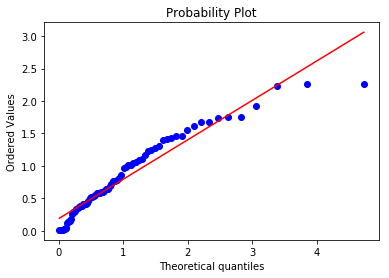



k = 5, size = 20
Number of positive jump times: 25
Mean: 0.3244


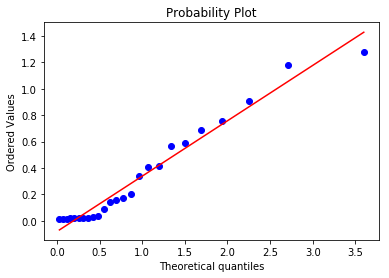



k = 6, size = 0
Number of positive jump times: 194
Mean: 1.2189278350515462


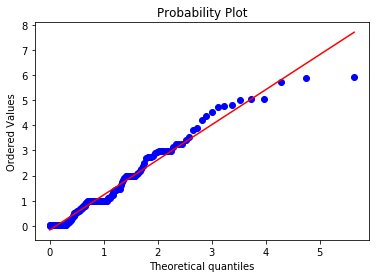



k = 6, size = 1
Number of positive jump times: 132
Mean: 0.5090681818181818


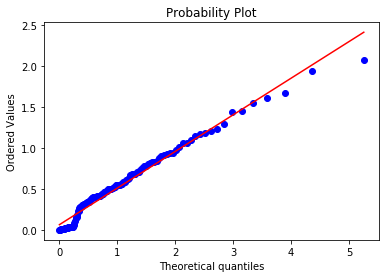



k = 6, size = 2
Number of positive jump times: 153
Mean: 0.9269607843137254


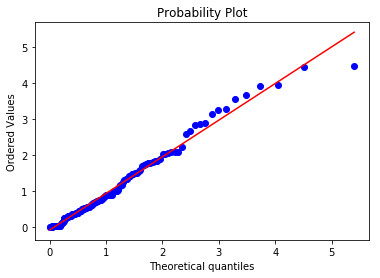



k = 6, size = 3
Number of positive jump times: 90
Mean: 0.6757000000000001


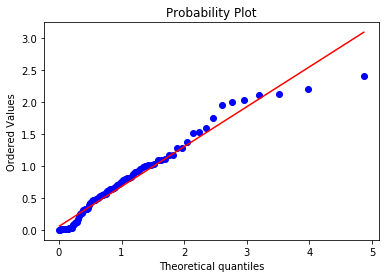



k = 6, size = 4
Number of positive jump times: 32
Mean: 0.22975


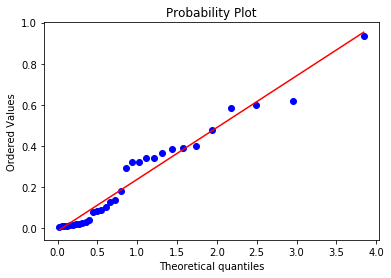



k = 6, size = 5
Number of positive jump times: 33
Mean: 0.3611212121212121


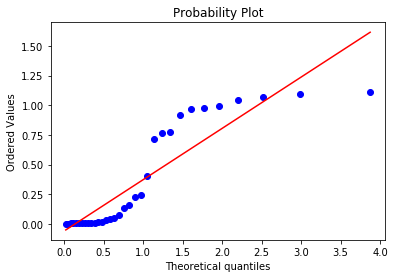



k = 7, size = 0
Number of positive jump times: 205
Mean: 1.3569463414634144


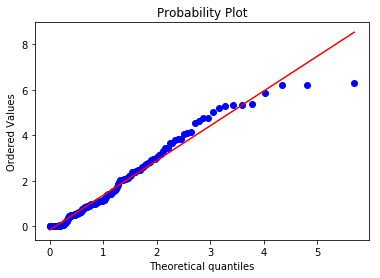



k = 7, size = 1
Number of positive jump times: 58
Mean: 2.5586551724137934


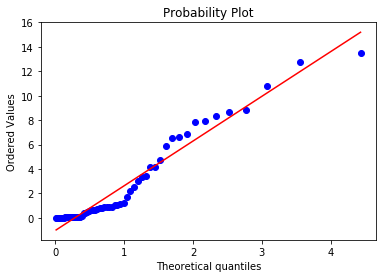



k = 7, size = 2
Number of positive jump times: 53
Mean: 1.0384528301886793


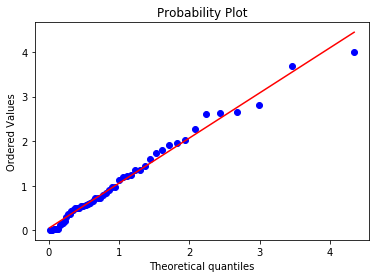



k = 7, size = 3
Number of positive jump times: 24
Mean: 0.6892083333333332


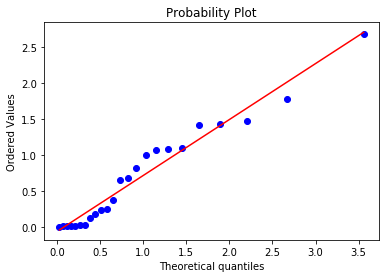



k = 7, size = 9
Number of positive jump times: 25
Mean: 0.029000000000000005


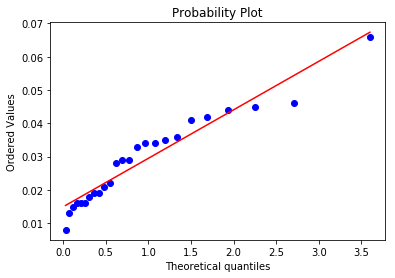



k = 7, size = 11
Number of positive jump times: 29
Mean: 0.39375862068965517


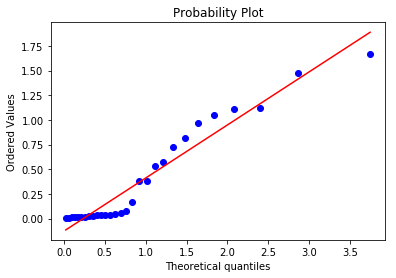



k = 7, size = 12
Number of positive jump times: 50
Mean: 1.0174400000000001


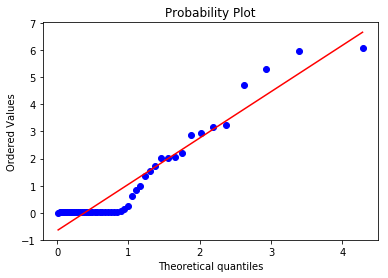



k = 7, size = 13
Number of positive jump times: 88
Mean: 0.5953522727272728


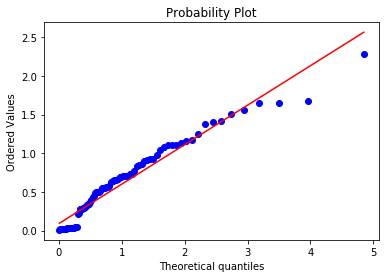



k = 8, size = 0
Number of positive jump times: 171
Mean: 0.6353976608187135


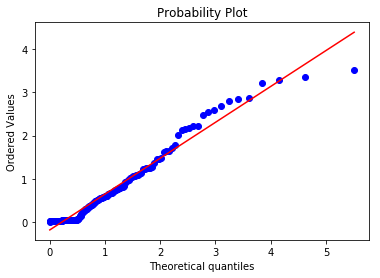



k = 8, size = 1
Number of positive jump times: 89
Mean: 0.3881797752808989


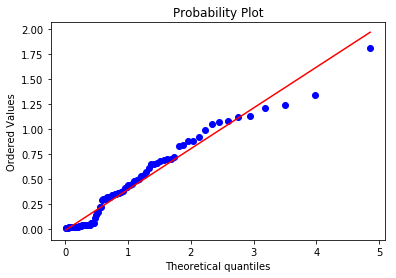



k = 8, size = 2
Number of positive jump times: 92
Mean: 0.5689130434782609


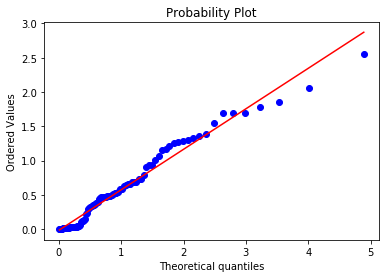



k = 8, size = 12
Number of positive jump times: 28
Mean: 0.5183214285714286


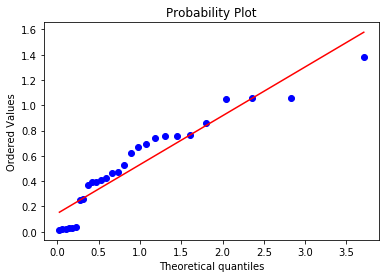



k = 8, size = 13
Number of positive jump times: 32
Mean: 0.6799062499999999


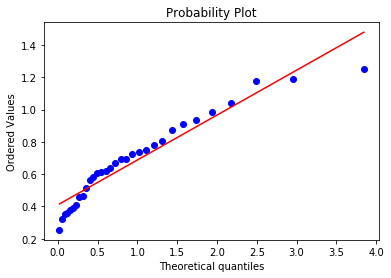



k = 9, size = 0
Number of positive jump times: 158
Mean: 1.3486329113924052


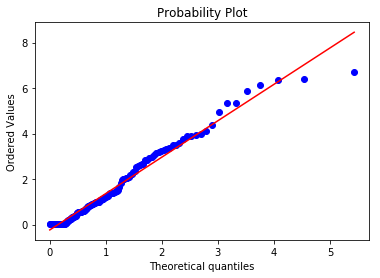



k = 9, size = 1
Number of positive jump times: 100
Mean: 0.5815100000000001


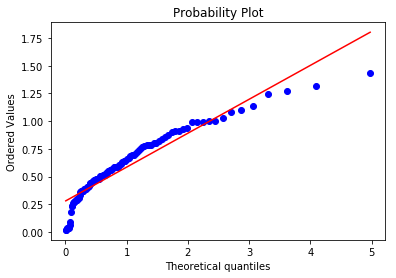



k = 9, size = 13
Number of positive jump times: 29
Mean: 0.8261034482758621


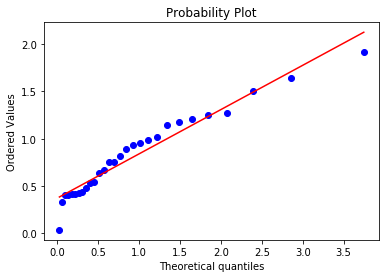



k = 9, size = 14
Number of positive jump times: 26
Mean: 0.8033076923076923


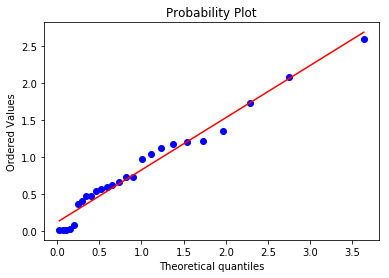



k = 10, size = 0
Number of positive jump times: 140
Mean: 0.8632285714285715


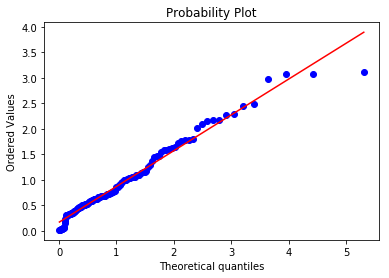



k = 10, size = 1
Number of positive jump times: 45
Mean: 0.8286666666666668


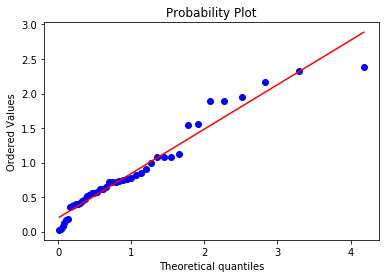



k = -8, size = 6
Number of negative jump times: 24
Mean: 2.0557916666666665


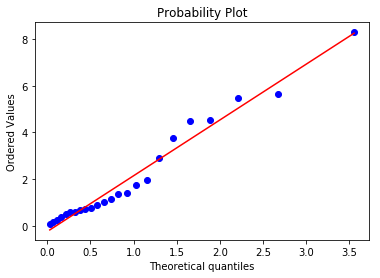



k = -7, size = 2
Number of negative jump times: 73
Mean: 1.9939589041095893


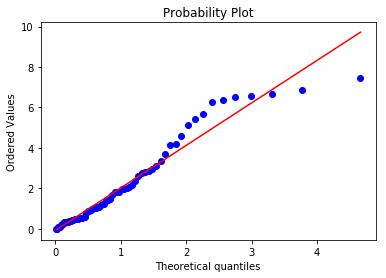



k = -7, size = 9
Number of negative jump times: 36
Mean: 2.9327500000000004


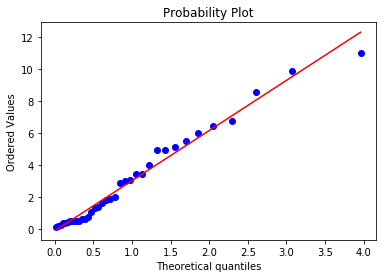



k = -6, size = 7
Number of negative jump times: 65
Mean: 3.2171538461538463


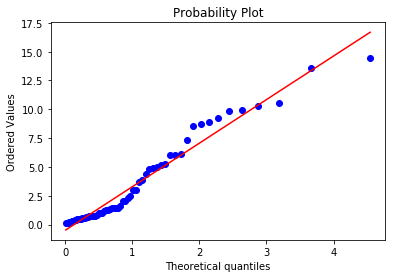



k = -6, size = 8
Number of negative jump times: 40
Mean: 2.83855


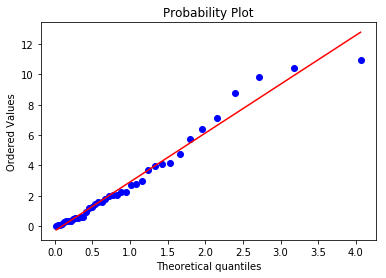



k = -6, size = 9
Number of negative jump times: 44
Mean: 5.08909090909091


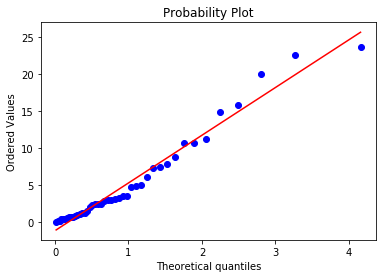



k = -6, size = 10
Number of negative jump times: 26
Mean: 3.181653846153847


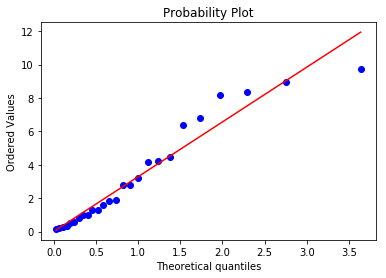



k = -5, size = 1
Number of negative jump times: 66
Mean: 1.5616060606060607


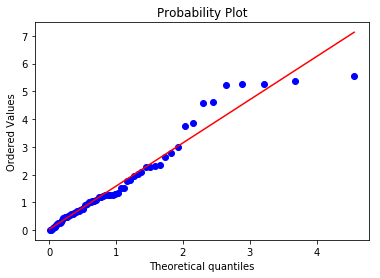



k = -5, size = 2
Number of negative jump times: 77
Mean: 2.5098571428571432


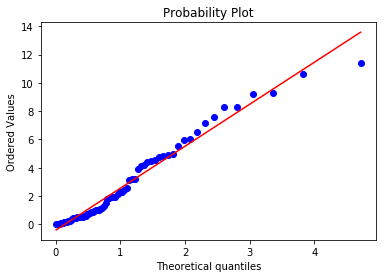



k = -5, size = 3
Number of negative jump times: 84
Mean: 2.675797619047619


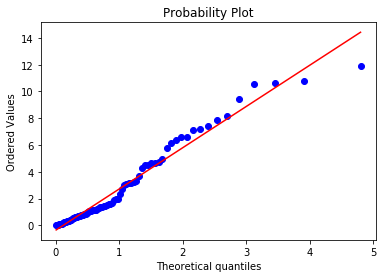



k = -5, size = 4
Number of negative jump times: 26
Mean: 1.3465


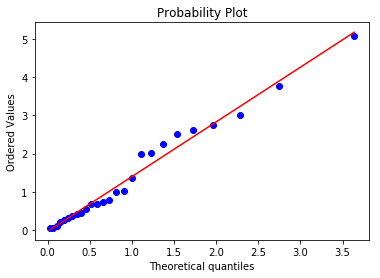



k = -5, size = 11
Number of negative jump times: 25
Mean: 3.41476


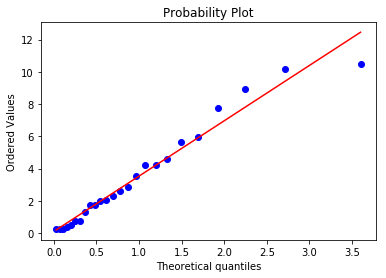



k = -4, size = 1
Number of negative jump times: 109
Mean: 2.8392385321100915


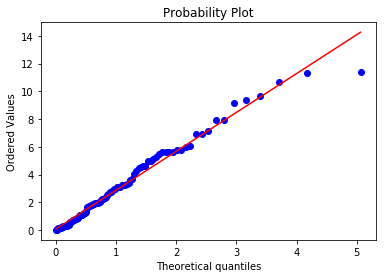



k = -4, size = 2
Number of negative jump times: 40
Mean: 2.196275


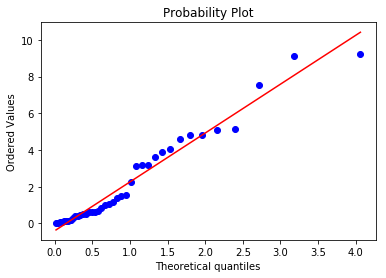



k = -4, size = 3
Number of negative jump times: 42
Mean: 3.7568333333333337


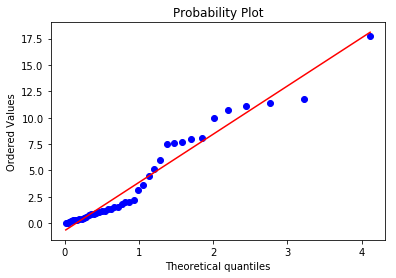



k = -4, size = 4
Number of negative jump times: 36
Mean: 1.3274166666666667


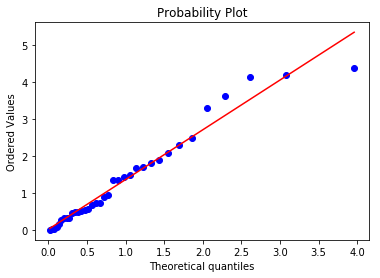



k = -4, size = 5
Number of negative jump times: 25
Mean: 2.7884800000000003


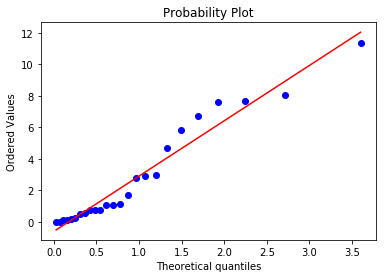



k = -4, size = 11
Number of negative jump times: 38
Mean: 1.864026315789474


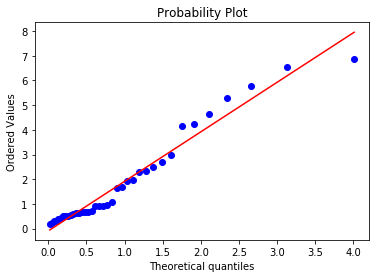



k = -4, size = 12
Number of negative jump times: 23
Mean: 2.61204347826087


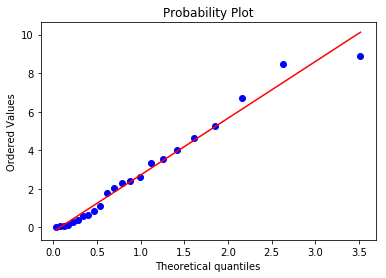



k = -3, size = 1
Number of negative jump times: 129
Mean: 1.1041395348837209


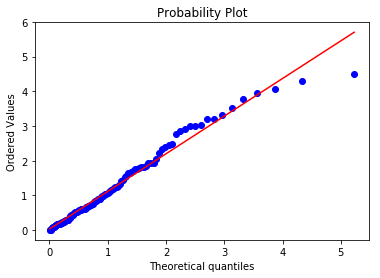



k = -3, size = 2
Number of negative jump times: 53
Mean: 2.152603773584906


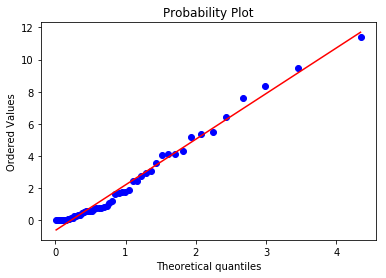



k = -3, size = 3
Number of negative jump times: 124
Mean: 1.9261129032258064


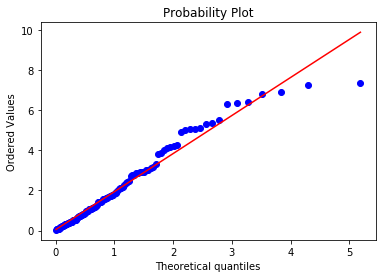



k = -3, size = 4
Number of negative jump times: 39
Mean: 3.007561512820513


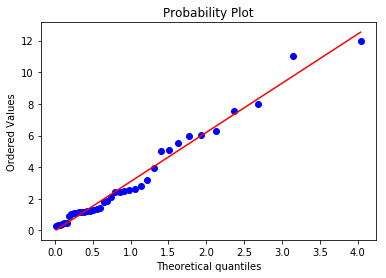



k = -3, size = 5
Number of negative jump times: 44
Mean: 2.554818181818182


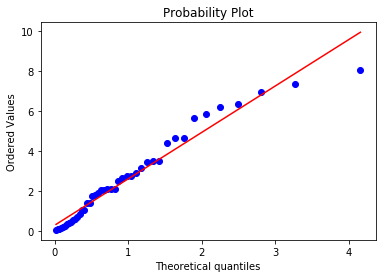



k = -3, size = 6
Number of negative jump times: 47
Mean: 2.1304468085106385


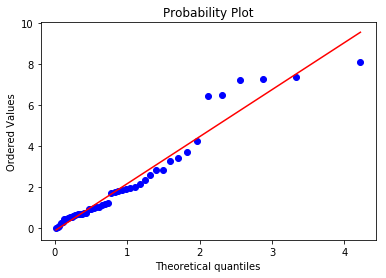



k = -3, size = 7
Number of negative jump times: 31
Mean: 2.03541935483871


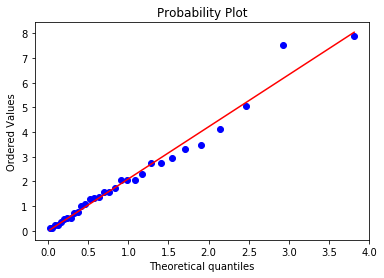



k = -3, size = 16
Number of negative jump times: 29
Mean: 4.146103448275863


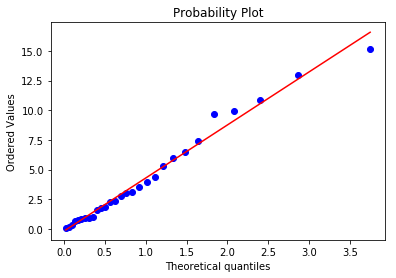



k = -2, size = 1
Number of negative jump times: 141
Mean: 1.4021631205673757


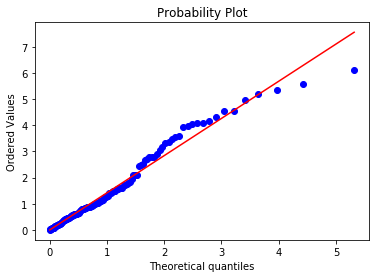



k = -2, size = 2
Number of negative jump times: 58
Mean: 2.8461896551724135


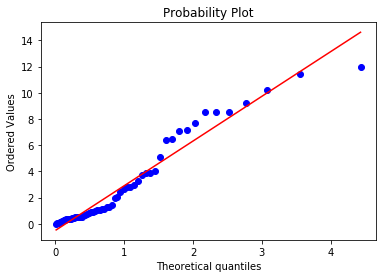



k = -2, size = 3
Number of negative jump times: 87
Mean: 1.9300459770114937


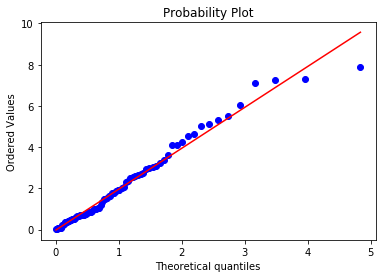



k = -2, size = 4
Number of negative jump times: 73
Mean: 2.058082191780822


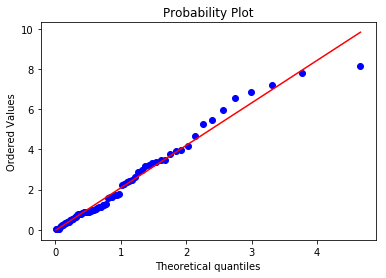



k = -2, size = 5
Number of negative jump times: 60
Mean: 1.4429


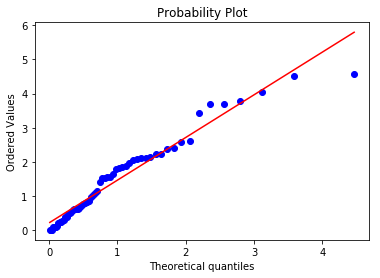



k = -2, size = 6
Number of negative jump times: 26
Mean: 4.010769230769231


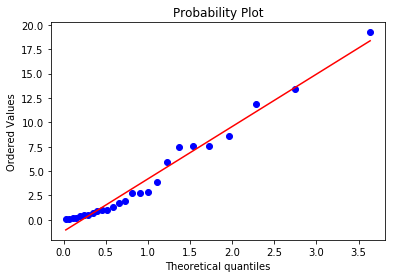



k = -2, size = 14
Number of negative jump times: 44
Mean: 4.023795454545454


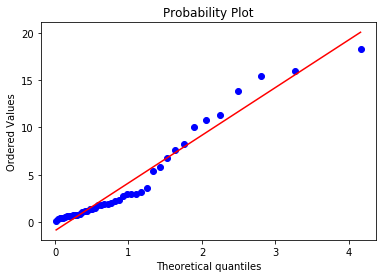



k = -2, size = 15
Number of negative jump times: 54
Mean: 3.4030555555555555


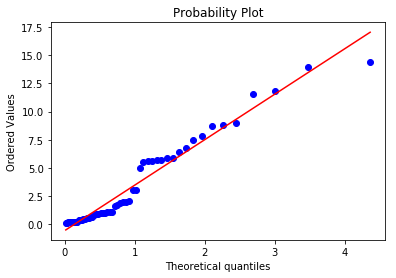



k = -2, size = 17
Number of negative jump times: 37
Mean: 5.312243243243243


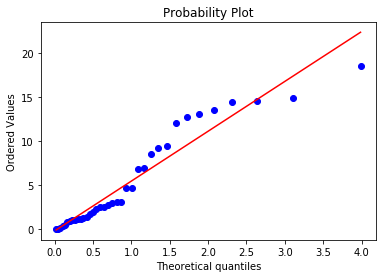



k = -1, size = 1
Number of negative jump times: 77
Mean: 4.100350649350649


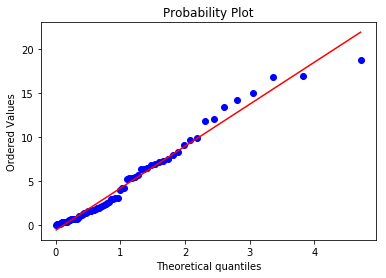



k = -1, size = 2
Number of negative jump times: 34
Mean: 3.6437352941176466


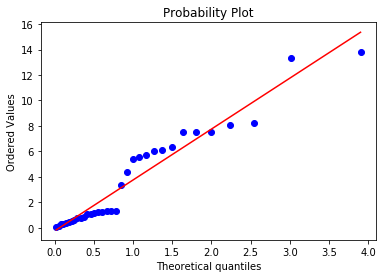



k = -1, size = 3
Number of negative jump times: 106
Mean: 0.8861132075471699


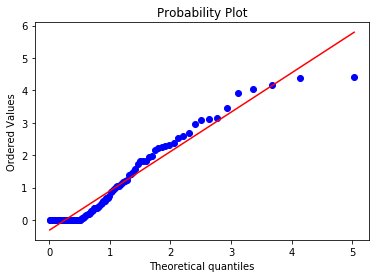



k = -1, size = 4
Number of negative jump times: 73
Mean: 2.0277945205479457


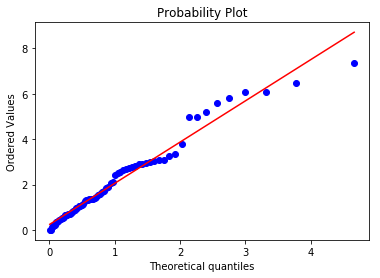



k = -1, size = 5
Number of negative jump times: 77
Mean: 2.8880779220779216


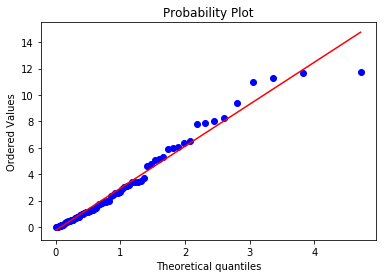



k = -1, size = 6
Number of negative jump times: 62
Mean: 5.226677419354838


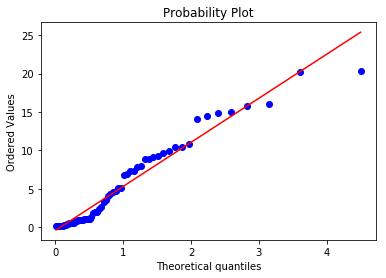



k = -1, size = 13
Number of negative jump times: 41
Mean: 2.789829268292683


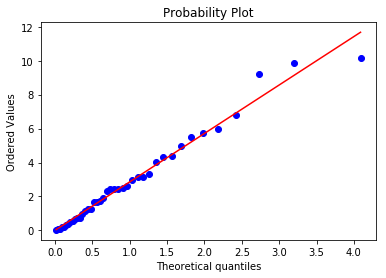



k = -1, size = 14
Number of negative jump times: 43
Mean: 2.4642325581395346


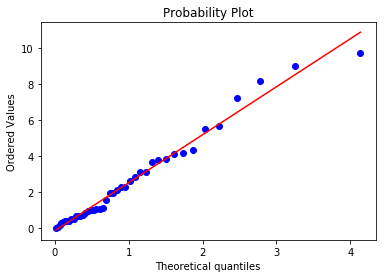



k = -1, size = 16
Number of negative jump times: 27
Mean: 5.154


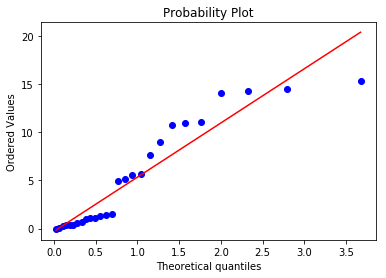



k = -1, size = 17
Number of negative jump times: 25
Mean: 2.64148


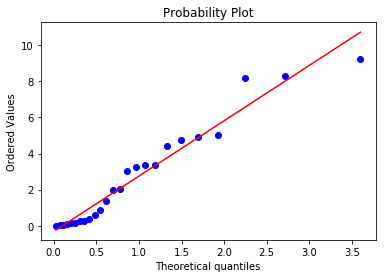



k = -1, size = 19
Number of negative jump times: 28
Mean: 2.061035714285714


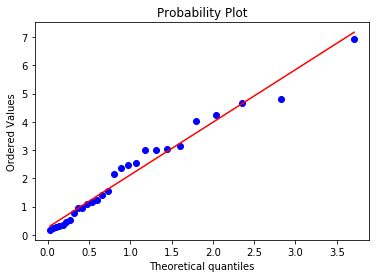



k = 1, size = 1
Number of negative jump times: 48
Mean: 6.218312500000001


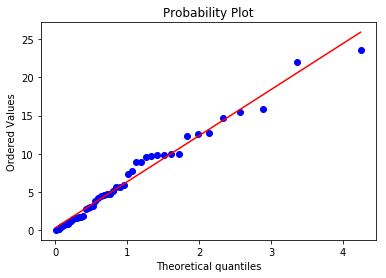



k = 1, size = 2
Number of negative jump times: 28
Mean: 4.522142857142858


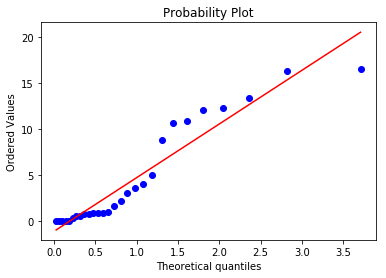



k = 1, size = 4
Number of negative jump times: 23
Mean: 5.92995652173913


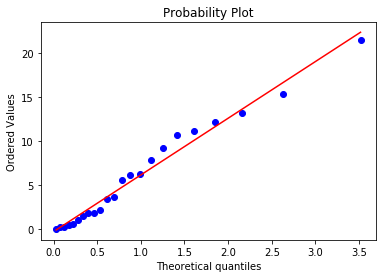



k = 1, size = 16
Number of negative jump times: 25
Mean: 3.91156


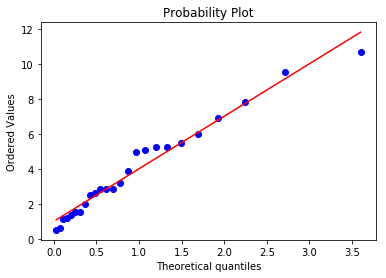



k = 1, size = 18
Number of negative jump times: 26
Mean: 16.114653846153846


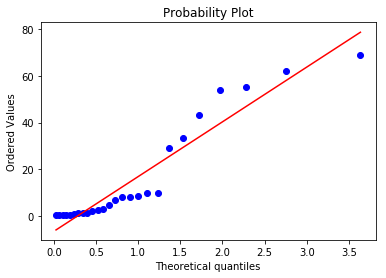



k = 2, size = 1
Number of negative jump times: 64
Mean: 1.921734375


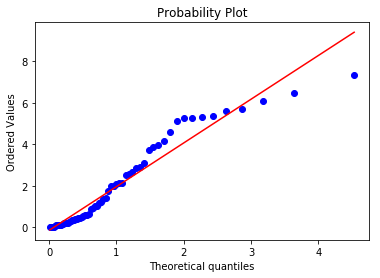



k = 2, size = 2
Number of negative jump times: 85
Mean: 4.1929058823529415


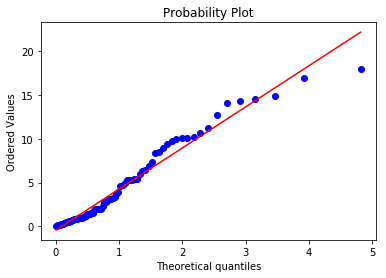



k = 2, size = 4
Number of negative jump times: 35
Mean: 2.543371428571428


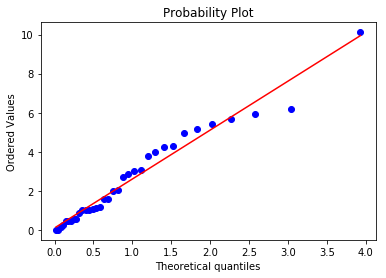



k = 2, size = 5
Number of negative jump times: 31
Mean: 0.7749032258064517


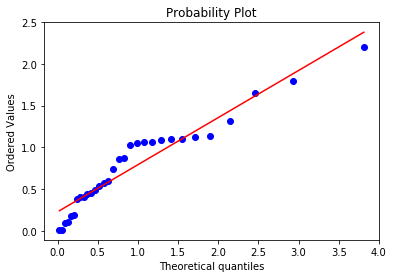



k = 2, size = 6
Number of negative jump times: 48
Mean: 0.8790208333333333


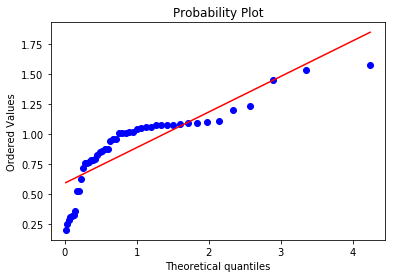



k = 2, size = 7
Number of negative jump times: 26
Mean: 2.5094230769230768


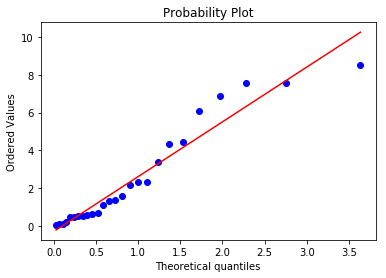



k = 3, size = 1
Number of negative jump times: 116
Mean: 3.402965517241379


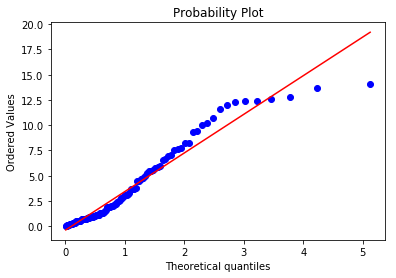



k = 3, size = 2
Number of negative jump times: 44
Mean: 4.3584772727272725


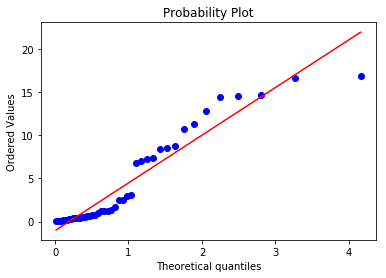



k = 3, size = 3
Number of negative jump times: 26
Mean: 1.987153846153846


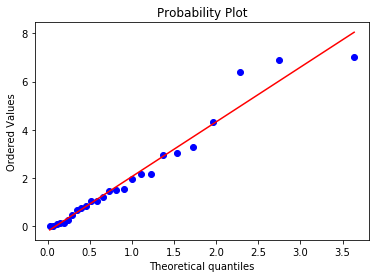



k = 3, size = 4
Number of negative jump times: 45
Mean: 1.7996444444444446


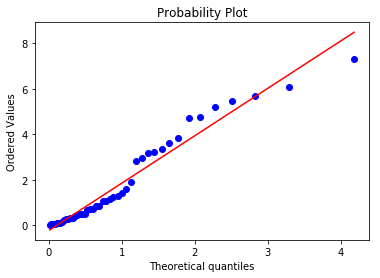



k = 3, size = 5
Number of negative jump times: 22
Mean: 4.236813590909091


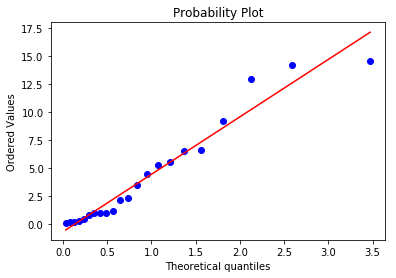



k = 3, size = 15
Number of negative jump times: 79
Mean: 2.986518987341772


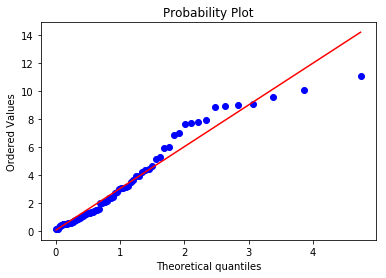



k = 4, size = 1
Number of negative jump times: 43
Mean: 1.2333488372093022


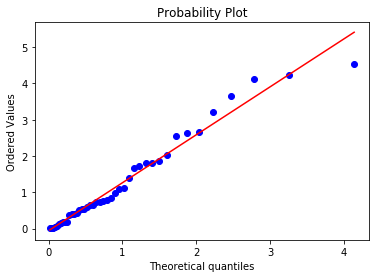



k = 4, size = 2
Number of negative jump times: 112
Mean: 1.8834821428571427


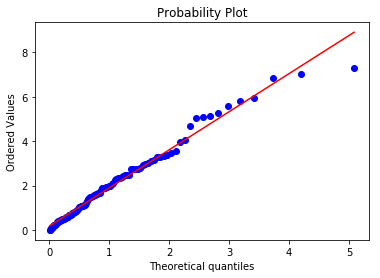



k = 4, size = 3
Number of negative jump times: 87
Mean: 3.3892298850574707


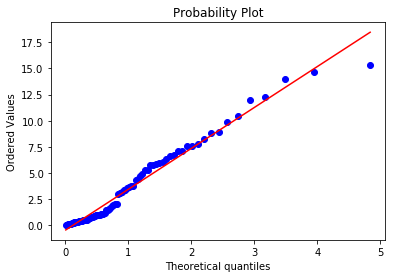



k = 4, size = 4
Number of negative jump times: 45
Mean: 0.8237555555555555


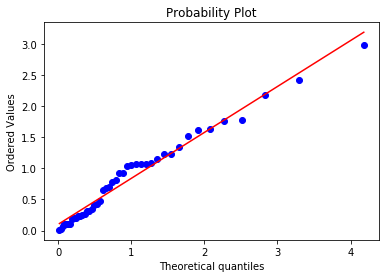



k = 4, size = 5
Number of negative jump times: 58
Mean: 1.5003103448275865


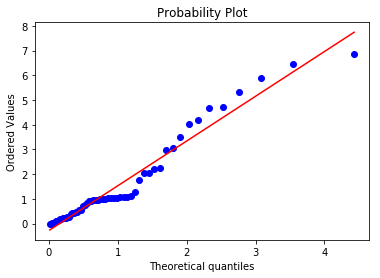



k = 4, size = 6
Number of negative jump times: 46
Mean: 0.8008260869565218


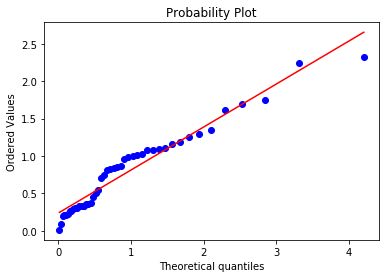



k = 4, size = 7
Number of negative jump times: 33
Mean: 0.5035151515151515


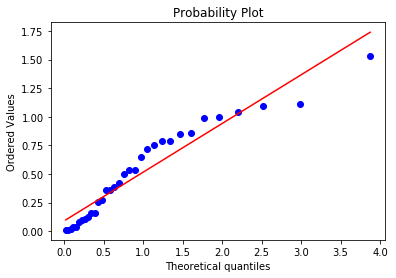



k = 4, size = 8
Number of negative jump times: 54
Mean: 0.7288148148148148


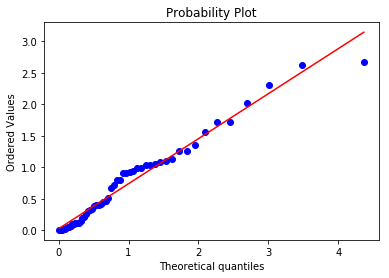



k = 4, size = 9
Number of negative jump times: 83
Mean: 0.6976144578313253


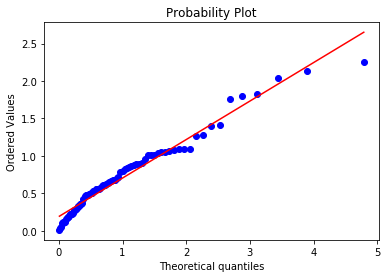



k = 5, size = 1
Number of negative jump times: 85
Mean: 1.7997176470588234


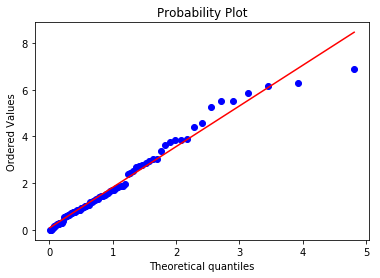



k = 5, size = 2
Number of negative jump times: 37
Mean: 0.8862162162162164


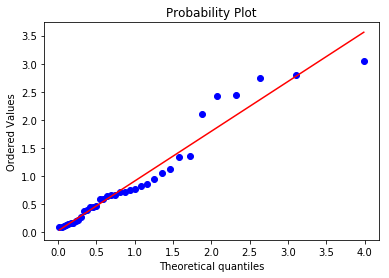



k = 5, size = 3
Number of negative jump times: 32
Mean: 1.7583124999999997


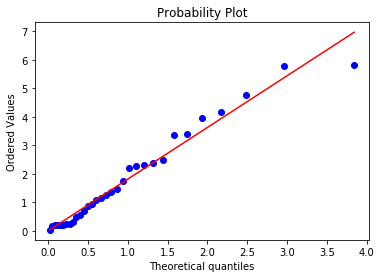



k = 5, size = 4
Number of negative jump times: 21
Mean: 0.829


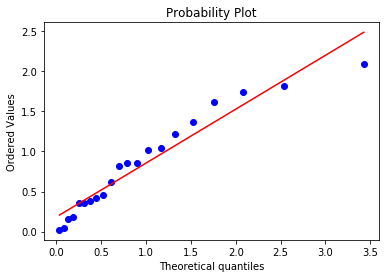



k = 5, size = 5
Number of negative jump times: 25
Mean: 1.39268


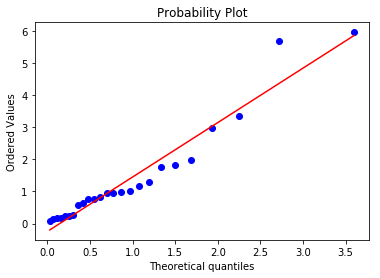



k = 5, size = 6
Number of negative jump times: 51
Mean: 0.818313725490196


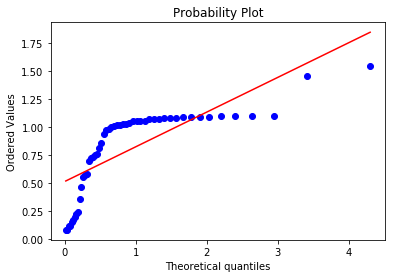



k = 5, size = 15
Number of negative jump times: 38
Mean: 4.8496578947368425


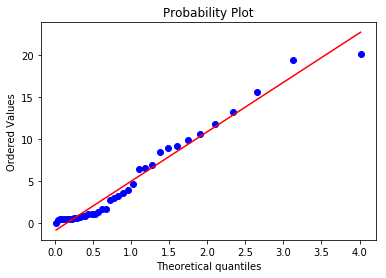



k = 5, size = 17
Number of negative jump times: 28
Mean: 1.1833214285714286


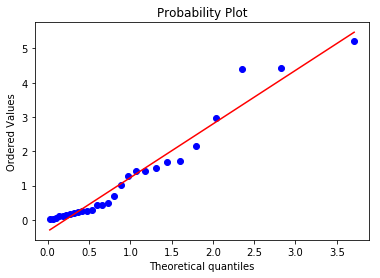



k = 5, size = 18
Number of negative jump times: 49
Mean: 2.486265306122449


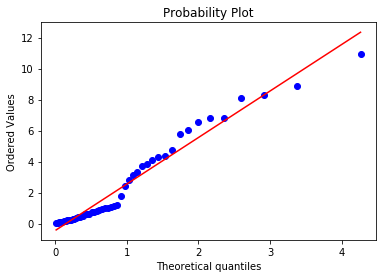



k = 5, size = 19
Number of negative jump times: 36
Mean: 3.3728333333333333


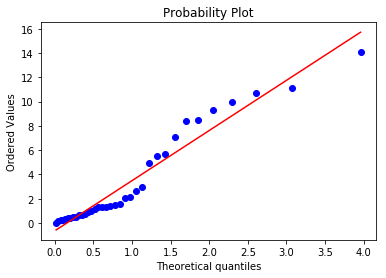



k = 5, size = 20
Number of negative jump times: 35
Mean: 5.449114285714286


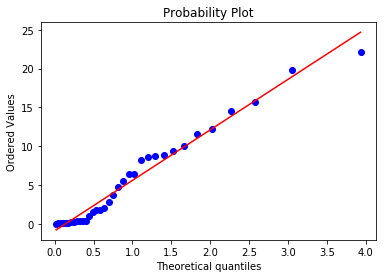



k = 5, size = 21
Number of negative jump times: 80
Mean: 1.3991375


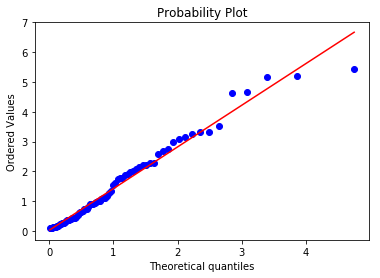



k = 6, size = 1
Number of negative jump times: 161
Mean: 4.211465838509317


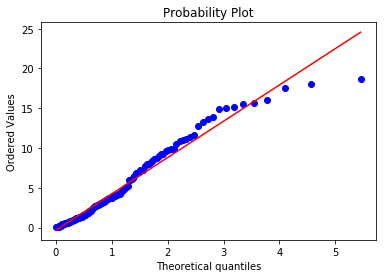



k = 6, size = 2
Number of negative jump times: 154
Mean: 1.203090909090909


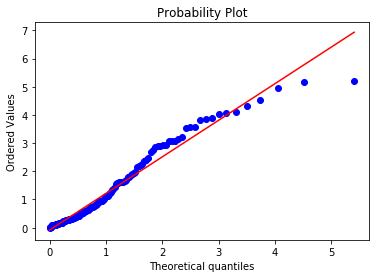



k = 6, size = 3
Number of negative jump times: 104
Mean: 2.9751923076923075


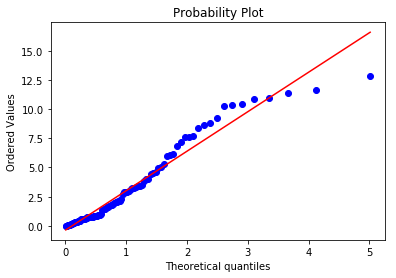



k = 6, size = 4
Number of negative jump times: 164
Mean: 0.954939024390244


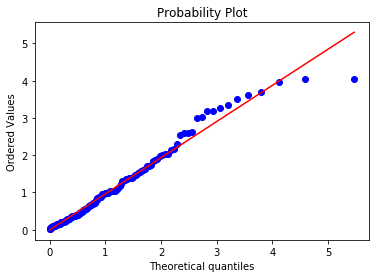



k = 6, size = 5
Number of negative jump times: 39
Mean: 0.8179230769230769


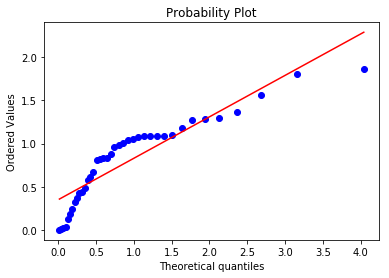



k = 7, size = 1
Number of negative jump times: 130
Mean: 2.9623692307692306


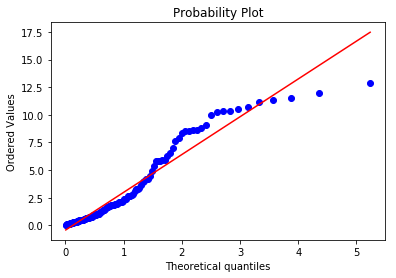



k = 7, size = 2
Number of negative jump times: 58
Mean: 2.7934482758620693


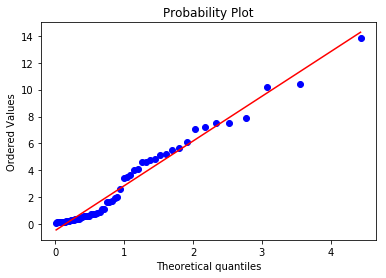



k = 7, size = 3
Number of negative jump times: 48
Mean: 0.6037083333333334


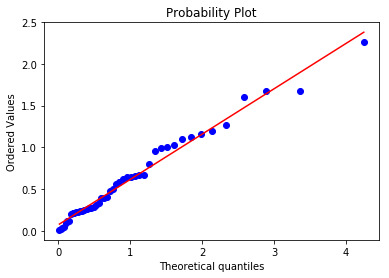



k = 7, size = 10
Number of negative jump times: 35
Mean: 3.371657142857143


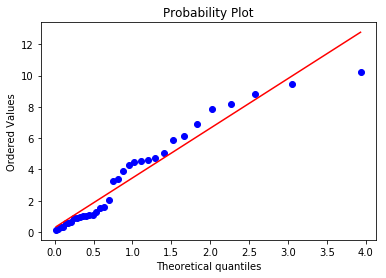



k = 7, size = 11
Number of negative jump times: 23
Mean: 4.867565217391305


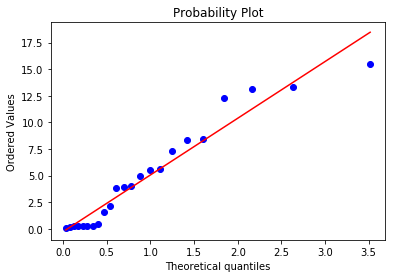



k = 7, size = 12
Number of negative jump times: 25
Mean: 1.32416


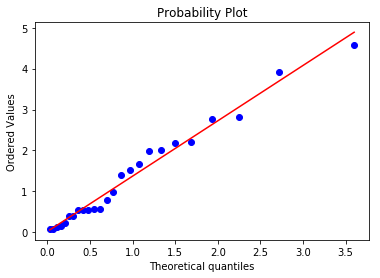



k = 7, size = 13
Number of negative jump times: 54
Mean: 7.352240740740742


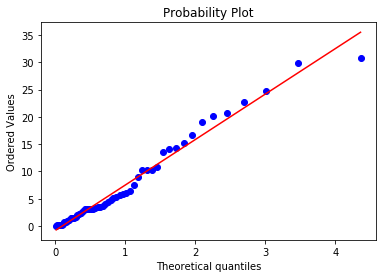



k = 7, size = 14
Number of negative jump times: 75
Mean: 0.9674266666666667


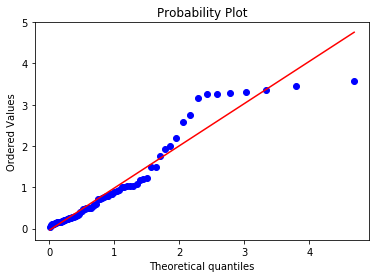



k = 8, size = 1
Number of negative jump times: 221
Mean: 3.2437330316742083


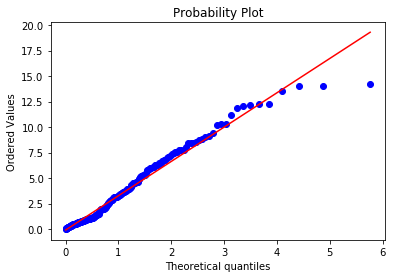



k = 8, size = 2
Number of negative jump times: 89
Mean: 1.0775280898876403


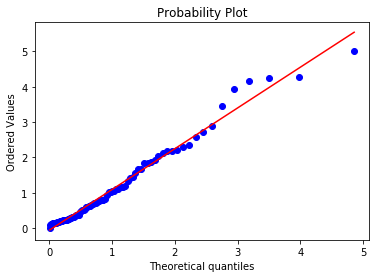



k = 8, size = 3
Number of negative jump times: 82
Mean: 0.9031707317073171


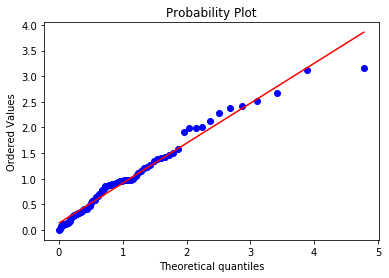



k = 8, size = 13
Number of negative jump times: 25
Mean: 1.1897600000000002


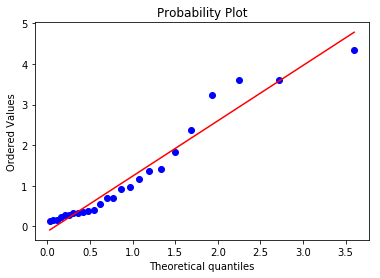



k = 8, size = 14
Number of negative jump times: 26
Mean: 0.6213076923076923


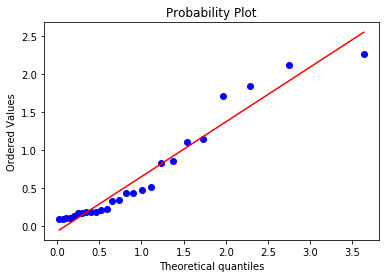



k = 9, size = 1
Number of negative jump times: 154
Mean: 2.1377597402597406


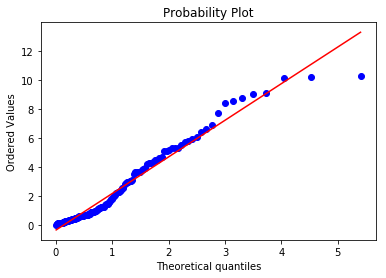



k = 9, size = 2
Number of negative jump times: 103
Mean: 0.5282815533980584


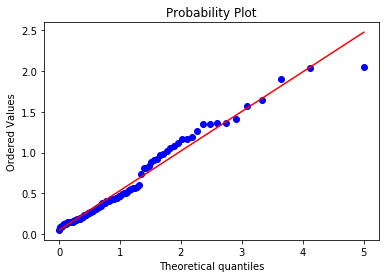



k = 9, size = 14
Number of negative jump times: 25
Mean: 0.36524


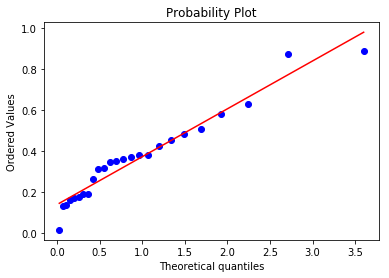



k = 9, size = 15
Number of negative jump times: 24
Mean: 0.6085416666666666


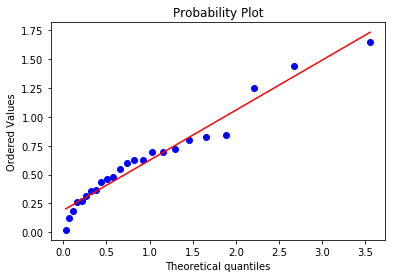



k = 10, size = 1
Number of negative jump times: 135
Mean: 0.6550074074074074


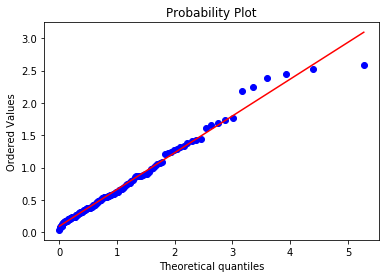



k = 10, size = 2
Number of negative jump times: 44
Mean: 0.786909090909091


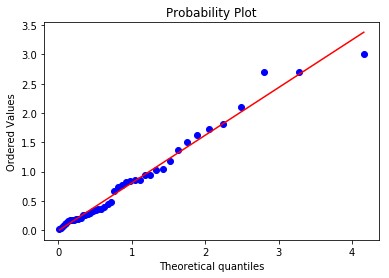

In [13]:
# Remove outliers
def without_outliers(data):
    if len(data) <= 3:
        return data
    quartiles = np.percentile(data,[25,50,75])
    IQR = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - 3*IQR
    upper_bound = quartiles[2] + 3*IQR
    return [d for d in data if d >= lower_bound and d <= upper_bound]


for k in time_between_events_pos:
    time_between_events_pos[k] = \
    OrderedDict([(s,without_outliers(ts)) for (s,ts) in time_between_events_pos[k].items()])
    time_between_events_pos[k] = \
    OrderedDict([(s,ts) for (s,ts) in time_between_events_pos[k].items() if len(ts) > 20])
# time_between_events_pos = OrderedDict([(k,d) for (k,d) in time_between_events_pos.items() if len(d) > 0])
        
for k in time_between_events_neg:
    time_between_events_neg[k] = \
    OrderedDict([(s,without_outliers(ts)) for (s,ts) in time_between_events_neg[k].items()])
    time_between_events_neg[k] = \
    OrderedDict([(s,ts) for (s,ts) in time_between_events_neg[k].items() if len(ts) > 20])    
# time_between_events_neg = OrderedDict([(k,d) for (k,d) in time_between_events_neg.items() if len(d) > 0])

       
for k,v in time_between_events_pos.items():
    for size,times in v.items():
        n = len(times)
        print("k = {}, size = {}".format(k,size))
        print("Number of positive jump times: {}".format(n))
        num_data_points = len(times)
        print("Mean: {}".format(np.mean(times)))
        probplot(times, dist=expon, plot=pylab)
        pylab.show()
        print("\n")

for k,v in time_between_events_neg.items():
    for size,times in v.items():
        n = len(times)
        print("k = {}, size = {}".format(k,size))
        print("Number of negative jump times: {}".format(n))
        num_data_points = len(times)
        print("Mean: {}".format(np.mean(times)))
        probplot(times, dist=expon, plot=pylab)
        pylab.show()
        print("\n")

# Compare to aribrtary exponential distribution

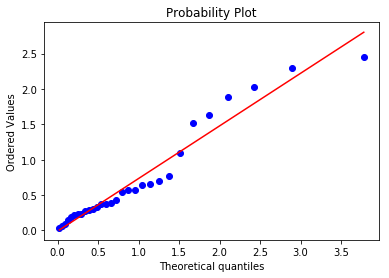

In [20]:
x = [np.random.exponential() for _ in range(30)]
kstest(x,'expon',args=(np.mean(x),))
probplot(x, dist=expon, plot=pylab)
pylab.show()

# Graph Arrival Rates

-10


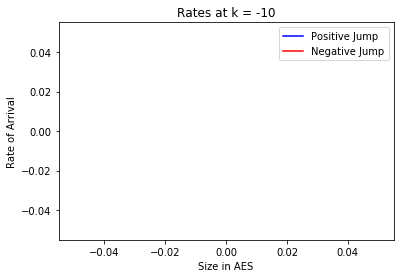

-9


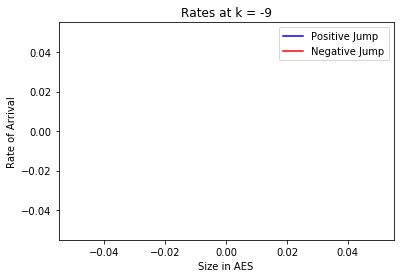

-8


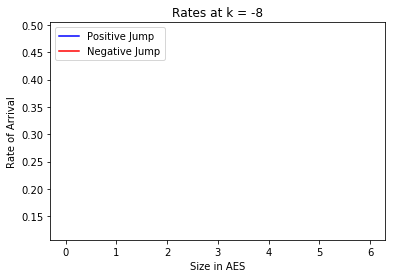

-7


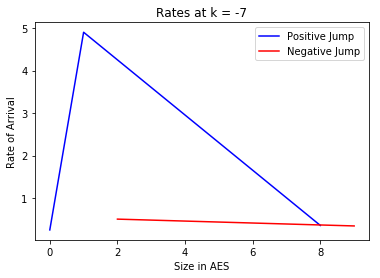

-6


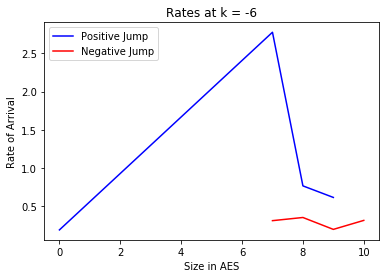

-5


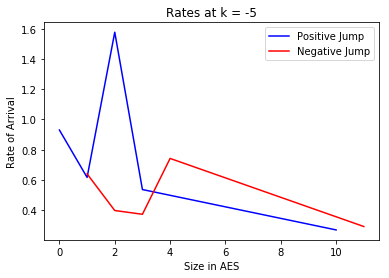

-4


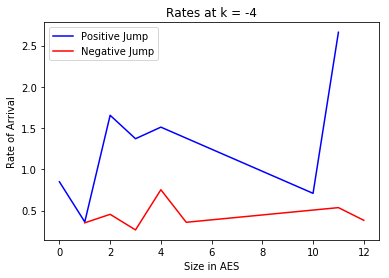

-3


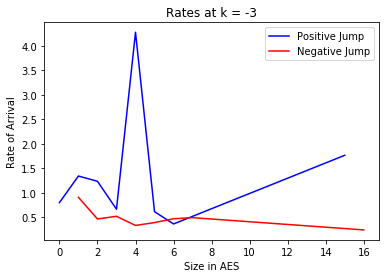

-2


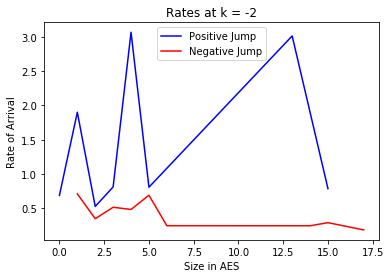

-1


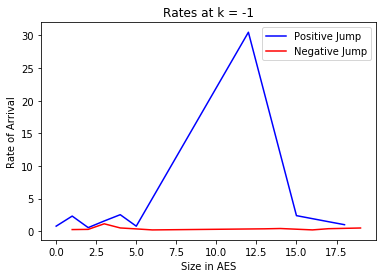

1


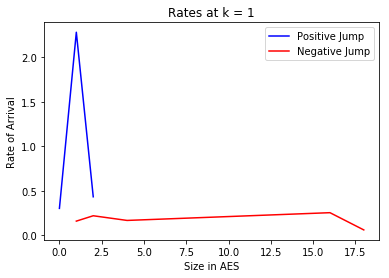

2


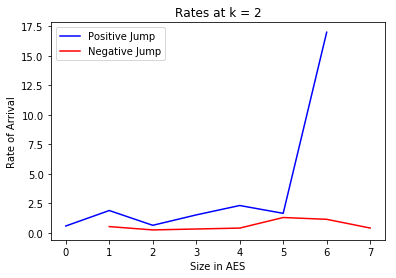

3


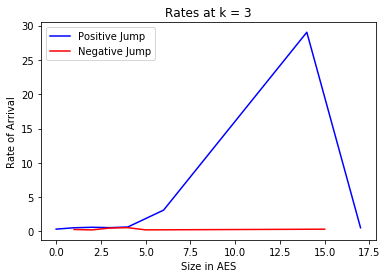

4


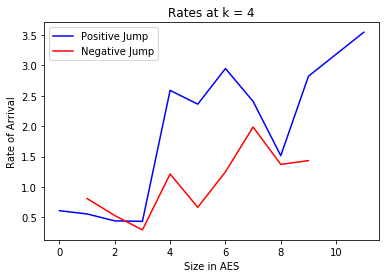

5


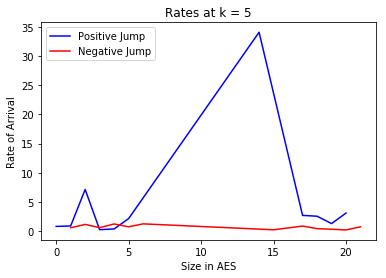

6


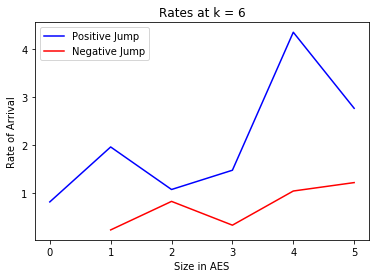

7


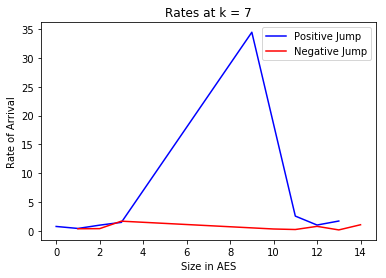

8


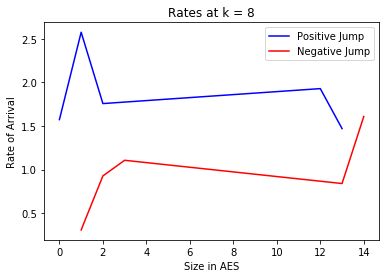

9


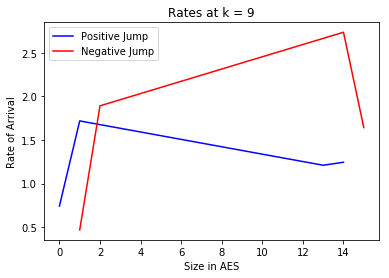

10


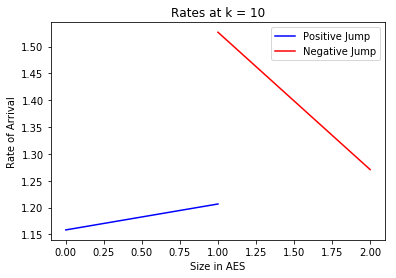

In [21]:
pos_rates_dict = OrderedDict([(k,OrderedDict()) for k in time_between_events_pos])
neg_rates_dict = OrderedDict([(k,OrderedDict()) for k in time_between_events_neg])

for k in pos_rates_dict:
    pos_rates_dict[k] = OrderedDict([(size,1/np.mean(times)) for size,times in time_between_events_pos[k].items()])
for k in neg_rates_dict:
    neg_rates_dict[k] = OrderedDict([(size,1/np.mean(times)) for size,times in time_between_events_neg[k].items()])

for k in range(-K,K+1):
    if k == 0:
        continue
    
    print(k)
        
    if len(pos_rates_dict[k]) > 0:
        pos_size,pos_rates = zip(*(pos_rates_dict[k].items()))
    else:
        pos_size,pos_rates = [],[]
        
    if len(neg_rates_dict[k]) > 0:
        neg_size,neg_rates = zip(*(neg_rates_dict[k].items()))
    else:
        neg_size,neg_rates = [],[]
        
    plt.plot(pos_size,pos_rates,'b')
    plt.plot(neg_size,neg_rates,'r')
    plt.xlabel('Size in AES')
    plt.ylabel('Rate of Arrival')
    plt.title('Rates at k = {}'.format(k))
    plt.legend(['Positive Jump', 'Negative Jump'])
    plt.show()
        
        